# Project Luther: Predicting the Market Value of NBA Players

Name: Paul Lim

Date: 04/28/2017

In [527]:
# Relevant libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import pipeline, feature_selection, decomposition
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import RFECV
import logging


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## List of Classes/Functions

In [695]:
# Running list of classes/functions

class IdentityTransform(BaseEstimator, TransformerMixin):
    '''
    Maintains the original matrix of features.
    '''
    def fit(self, x, y=None):
        return self

    def transform(self, X):
        return X

def bball_get_col(table, col_tag='th'):
    '''
    The columns of the table should be in the first 'tr' tag within the table tag.  
    The columns will be found as either 'th' or 'td' tags within the 'tr' tag.  
    The 'th' tag is set as default.
    '''
    col_loc = table.find('tr')
    cols = col_loc.find_all(col_tag)

    cols_list = []
    for i in range(len(cols)):
        temp_col = cols[i].get_text()
        cols_list.append(temp_col)
        
    return cols_list

def bball_get_data(table, data_tag='td'):
    '''
    The data within a table should be the second through last 'tr' tag within the table tag.
    The data should be found as 'td' tags, so the default data tag is set to 'td'.
    '''
    all_rows = table.find_all('tr')[1:]

    all_data = []

    for i in range(len(all_rows)):
        row = all_rows[i].find_all('th')
        add_row = all_rows[i].find_all('td')
        row.extend(add_row)
        data = []
        for j in range(len(row)):
            datapoint = row[j].get_text()
            data.append(datapoint)
        all_data.append(data)
        
    return all_data

def bball_scrape_data(url_template, start_year, end_year, delay=5):
    '''
    The url_template should be a formatted string where the start_year and end_year can be cycled through.
    The start_year and end_year should be integers.
    The col_list should be a list.
    The default data_tag is 'td'.
    The delay, which delays each run through of the for loop, is set to 5 seconds as default.  
    The delay prevents the scraper from being blocked due to frequent scraping requests.
    '''
    df = pd.DataFrame()
    
    if start_year > end_year:
        return print('Enter in valid end year.')
    else: 
        for year in range(start_year, end_year+1):
            try:
                url = url_template.format(year=year)
                link = requests.get(url)
            except:
                print(url)
                print('Check to make sure the URL is correct!')
            
            print(url)
            page = link.text

            soup = BeautifulSoup(page, 'lxml')
            table = soup.find('table')

            col_list = bball_get_col(table)
            all_data = bball_get_data(table)
            
            if not col_list or not all_data:
                print(url)
                print('Webpage may be empty.')
                pass
            elif len(col_list) != len(all_data[0]):
                print('Column List: \n', col_list)
                print('Data Row: \n', all_data)
                return print('Make sure the length of columns and data are consistent!')
            else:
                temp_df = pd.DataFrame(all_data, columns=col_list)
                temp_df = temp_df.assign(Yr = year)
                df = df.append(temp_df)
            time.sleep(delay)

    return df




def sal_get_col(table_sal):
    '''
    Column headers were found in the 'td' tags within the first 'tr' tag.
    '''
    col_loc_sal = table_sal.find('tr')
    cols_sal = col_loc_sal.find_all('td')

    cols_list_sal = []
    for i in range(len(cols_sal)):
        temp_col_sal = cols_sal[i].get_text()
        cols_list_sal.append(temp_col_sal)
    return cols_list_sal

def sal_get_data(table_sal):
    '''
    All of the data were found in the 'td' tags within the 'tr' tags that had the class 'evenrow' or 'oddrow'.
    '''
    all_rows_sal = table_sal.find_all('tr', class_ = ['evenrow', 'oddrow'])

    all_data_sal = []

    for i in range(len(all_rows_sal)):
        row_sal = all_rows_sal[i].find_all('td')
        data_sal = []
        for j in range(len(row_sal)):
            datapoint_sal = row_sal[j].get_text()
            data_sal.append(datapoint_sal)
        all_data_sal.append(data_sal)
        
    return all_data_sal

def sal_scrape_data(url_template, start_year, end_year, start_page, end_page, delay=5):
    '''
    Function to scrape the salary data from ESPN.com. The url_template should be a formattable
    string that takes in the start_year through the end_year. Since each year had multiple pages
    the url_template should also be able to take in the start_page through the end_page.
    '''
    df = pd.DataFrame()
    
    if start_year > end_year:
        return print('Enter in valid end year.')
    elif start_page > end_page:
        return pring('Enter in a valid end page.')
    else: 
        for year in range(start_year, end_year+1):
            for page in range(start_page, end_page+1):
                try:
                    url = url_template.format(year=year, page=page)
                    link = requests.get(url)
                except:
                    print(url)
                    print('Check to make sure the URL is correct!')
                
                page = link.text

                soup = BeautifulSoup(page, 'lxml')
                table = soup.find('table')

                col_list = sal_get_col(table)
                all_data = sal_get_data(table)
                
                if not col_list or not all_data:
                    print(url)
                    print('Webpage may be empty.')
                    pass
                elif len(col_list) != len(all_data[0]):
                    print('Column List: \n', col_list)
                    print('Data Row: \n', all_data)
                    return print('Make sure the length of columns and data are consistent!')
                else:
                    temp_df = pd.DataFrame(all_data, columns=col_list)
                    temp_df = temp_df.assign(Yr = year)
                    df = df.append(temp_df)
                time.sleep(delay)
                
    return df


def square_features(df, col_list):
    '''
    Function that creates the squared term of the features in the col_list.
    The dataframe that is returned contains the original features with the additional squared features.
    '''
    for col in col_list:
        new_col_name = col + '_sq'
        df[new_col_name] = df[col].apply(lambda x: x**2)
    return df

def cube_features(df, col_list):
    '''
    Function that creates the cubed term of the features in the col_list.
    The dataframe that is returned contains the original features with the additional cubed features.
    '''
    for col in col_list:
        new_col_name = col + '_cube'
        df[new_col_name] = df[col].apply(lambda x: x**3)
    return df

def rank_features(df, groupby_list, rank_list):
    '''
    Function that ranks the players in the particular groupby object specified by the groupby_list.
    The dataframe that is returned contains the original features with the additional ranked features.
    '''
    df_rank = df.groupby(groupby_list).rank(ascending=True)
    new_col_list = []
    for col in rank_list:
        new_col_name = col + '_rk'
        df_rank[new_col_name] = df_rank[col]
        new_col_list.append(new_col_name)
    return df_rank[new_col_list]


def rand_features(df, col_names):
    '''
    Function that creates noisy features that contain integers between 0 and 10000.
    The dataframe that is returned contains the original dataframe with the additional noisy features.
    '''
    for col in col_names:
        df[col] = np.random.randint(0,10000,len(df))
    return df


def run_pipelines(model_dict, X, y, feature_list, param_dict):
    '''
    Runs through a pipeline for each type of model.
    feature_list = list of tuples.
    param_dict = a nested dictionary that contains the hyper parameters that need to be tuned.
    '''
    logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
    grid_dict = {}
    
    for name, model in sorted(model_dict.items()):
        if feature_list:
            combined_features = pipeline.FeatureUnion(feature_list)

            steps = [
                ('features', combined_features),
                ('feature_selection', feature_selection.SelectFromModel(linear_model.Lasso(alpha=2))),
                ('model', model)
                ]
        else:
            steps = [
                ('feature_selection', feature_selection.SelectFromModel(linear_model.Lasso(alpha=2))),
                ('model', model)
                ]
        
        regression_pipeline = pipeline.Pipeline(steps)
        if name in param_dict:
            parameters = param_dict[name]
        else:
            return print('Incorrect parameters in the parameter dictionary.')
            
        grid_dict[name] = GridSearchCV(regression_pipeline, parameters, n_jobs=3, verbose=1)
        train_fit = grid_dict[name].fit(X_train, y_train)
        print('Model: ', name)
        print('Best Score: %0.3f' % train_fit.best_score_)
        print('Optimal Parameters: ', train_fit.best_params_)
         
    return grid_dict


def fit_models(model_dict, df, col_list, target):
    '''
    Similar to the run_pipelines function. This function runs a 5-fold cross-validation on the models
    defined in the model_dict. The models are fit to the training and test sets from the df and the target
    that is specified in the inputs.
    '''
    X = df.loc[:,col_list]
    y = df.loc[:,target]
    
    X_arr = X.as_matrix()
    y_arr = y.as_matrix()
    
    list_scores = []
    list_dict = []
    total_model_dict = {}
    kf = KFold(n=len(X_arr), n_folds=5)
    for name, model in sorted(model_dict.items()):

        temp_score_list = []
        temp_train_score_list = []
        for split_indices in kf:
            train_ind = list(split_indices[0])
            test_ind = list(split_indices[1])
            
            X_train = X_arr[train_ind]
            X_test = X_arr[test_ind]
            y_train = y_arr[train_ind]
            y_test = y_arr[test_ind]
            
            model.fit(X_train, y_train)
            if hasattr(model, 'score'):
                temp_score = model.score(X_test, y_test)
                temp_score_list.append(temp_score)
            
                temp_train_score = model.score(X_train, y_train)
                temp_train_score_list.append(temp_train_score)
            elif hasattr(model, 'score_'):
                temp_score = model.score_(X_test, y_test)
                temp_score_list.append(temp_score)
            
                temp_train_score = model.coef_(X_train, y_train)
                temp_train_score_list.append(temp_train_score)
            if name not in total_model_dict:
                total_model_dict[name] = []
            else:
                total_model_dict[name].append(model)

        print('Model: ' + name)
        print('Test Score: ' + str(np.mean(temp_score_list)) + ' with STD: ' + str(np.std(temp_score_list)))
        print('Train Score: ' + str(np.mean(temp_train_score_list)) + ' with STD: ' + str(np.std(temp_train_score_list)))
    return total_model_dict


def plot_overfit(X,y,model_obj,param_ranges,param_static=None): 
    '''
    Function that outputs the plot of the hyper parameter versus the score.
    '''
    for parameter,parameter_range in param_ranges.items():
        avg_train_score, avg_test_score = [],[]
        std_train_score, std_test_score = [],[]
        
        for param_val in parameter_range:
            param = {parameter:param_val}
            if param_static:
                param.update(param_static)
                
            model = model_obj(**param)
            
            train_scores,test_scores = [],[]
            for i in range(5):
                X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .3)
                model.fit(X_train,y_train)
                
                train_scores.append(model.score(X_train,y_train))
                test_scores.append(model.score(X_test,y_test))
            
            avg_train_score.append(np.mean(train_scores))
            avg_test_score.append(np.mean(test_scores))
            
            std_train_score.append(np.std(train_scores))
            std_test_score.append(np.std(test_scores))
            
        fig,ax = plt.subplots()
        
        if parameter == 'alpha':
            ax.errorbar(np.log(parameter_range),avg_train_score,yerr=std_train_score,label='training score')
            ax.errorbar(np.log(parameter_range),avg_test_score,yerr=std_test_score,label='testing score')
            ax.set_xlabel('ln(' + parameter + ')', fontsize='14')
        else:
            ax.errorbar(parameter_range,avg_train_score,yerr=std_train_score,label='training score')
            ax.errorbar(parameter_range,avg_test_score,yerr=std_test_score,label='testing score')  
            ax.set_xlabel(parameter)
            
        ax.set_ylabel('score', fontsize='14')
        ax.set_title(parameter + ' tuning', fontsize='16')
        ax.legend(loc=0, frameon=True)
        sns.set_style("white")
        sns.set_style('ticks')
        sns.set_style({'xtick.direction': u'in', 'ytick.direction': u'in'})
        ttl = ax.title
        ttl.set_position([.5, 1.05])


## Basketball-reference Web Scrape

In [529]:
# Test the web scrape
url_bball = 'http://www.basketball-reference.com/leagues/NBA_2016_totals.html'
link_bball = requests.get(url_bball)
page_bball = link_bball.text

soup_bball = BeautifulSoup(page_bball, 'lxml')
table_bball = soup_bball.find('table')

### Get column headers

In [530]:
# Pull column names from the table
# th should be in the first tr tag
col_loc_bball = table_bball.find('tr')
cols_bball = col_loc_bball.find_all('th')

cols_list_bball = []
for i in range(len(cols_bball)):
    temp_col_bball = cols_bball[i].get_text()
    cols_list_bball.append(temp_col_bball)

### Get data

In [531]:
# Pull data from the table
# td tags in the second through last tr tag should contain all of the data
all_rows_bball = table_bball.find_all('tr')[1:]

all_data_bball = []

for i in range(len(all_rows_bball)):
    row_bball = all_rows_bball[i].find_all('td')
    data_bball = []
    for j in range(len(row_bball)):
        datapoint_bball = row_bball[j].get_text()
        data_bball.append(datapoint_bball)
    all_data_bball.append(data_bball)

# Remove the first column name since it is just another index of the player list
df_2016 = pd.DataFrame(all_data_bball, columns=cols_list_bball[1:])

### Combine the above three steps into one function

In [532]:
# Combine the above steps into one function that can run through multiple urls

# Get the advanced data from 2000 to 2016

bball_ref_url = 'http://www.basketball-reference.com/leagues/NBA_{year}_advanced.html'
start_year = 2000
end_year = 2017

df_bball = bball_scrape_data(bball_ref_url, start_year, end_year)
df_bball.head()
        

http://www.basketball-reference.com/leagues/NBA_2000_advanced.html
http://www.basketball-reference.com/leagues/NBA_2001_advanced.html
http://www.basketball-reference.com/leagues/NBA_2002_advanced.html
http://www.basketball-reference.com/leagues/NBA_2003_advanced.html
http://www.basketball-reference.com/leagues/NBA_2004_advanced.html
http://www.basketball-reference.com/leagues/NBA_2005_advanced.html
http://www.basketball-reference.com/leagues/NBA_2006_advanced.html
http://www.basketball-reference.com/leagues/NBA_2007_advanced.html
http://www.basketball-reference.com/leagues/NBA_2008_advanced.html
http://www.basketball-reference.com/leagues/NBA_2009_advanced.html
http://www.basketball-reference.com/leagues/NBA_2010_advanced.html
http://www.basketball-reference.com/leagues/NBA_2011_advanced.html
http://www.basketball-reference.com/leagues/NBA_2012_advanced.html
http://www.basketball-reference.com/leagues/NBA_2013_advanced.html
http://www.basketball-reference.com/leagues/NBA_2014_advanced.

Rk               Player Pos Age   Tm   G    MP   PER   TS%  3PAr  ...   \
0  1    Tariq Abdul-Wahad  SG  25  TOT  61  1578  13.6  .477  .036  ...    
1  1    Tariq Abdul-Wahad  SG  25  ORL  46  1205  14.4  .484  .041  ...    
2  1    Tariq Abdul-Wahad  SG  25  DEN  15   373  10.8  .448  .015  ...    
3  2  Shareef Abdur-Rahim  SF  23  VAN  82  3223  20.2  .547  .075  ...    
4  3       Cory Alexander  PG  26  DEN  29   329   8.8  .381  .357  ...    

    OWS  DWS    WS   WS/48    OBPM  DBPM   BPM  VORP    Yr  
0   0.4  1.8   2.2    .068    -1.6   0.1  -1.5   0.2  2000  
1   0.4  1.6   2.0    .082    -1.3   0.4  -0.8   0.4  2000  
2   0.0  0.2   0.2    .023    -2.8  -1.0  -3.8  -0.2  2000  
3   6.2  2.6   8.8    .132     1.8   0.5   2.3   3.5  2000  
4  -0.5  0.4  -0.1  -0.012    -3.6   0.1  -3.5  -0.1  2000  

[5 rows x 30 columns]

### Save dataframe to csv file

In [533]:
# Save the dataframe to a csv file
df_bball.to_csv('data/bball_ref_player_database.csv')

### Repeat the process for the non-advanced stats for players

In [534]:
bball_tot_url = 'http://www.basketball-reference.com/leagues/NBA_{year}_totals.html'
bball_per_url = 'http://www.basketball-reference.com/leagues/NBA_{year}_per_game.html'

start_year = 2000
end_year = 2017

df_bball_tot = bball_scrape_data(bball_tot_url, start_year, end_year)
print(df_bball_tot.head())

df_bball_per = bball_scrape_data(bball_per_url, start_year, end_year)
print(df_bball_per.head())

http://www.basketball-reference.com/leagues/NBA_2000_totals.html
http://www.basketball-reference.com/leagues/NBA_2001_totals.html
http://www.basketball-reference.com/leagues/NBA_2002_totals.html
http://www.basketball-reference.com/leagues/NBA_2003_totals.html
http://www.basketball-reference.com/leagues/NBA_2004_totals.html
http://www.basketball-reference.com/leagues/NBA_2005_totals.html
http://www.basketball-reference.com/leagues/NBA_2006_totals.html
http://www.basketball-reference.com/leagues/NBA_2007_totals.html
http://www.basketball-reference.com/leagues/NBA_2008_totals.html
http://www.basketball-reference.com/leagues/NBA_2009_totals.html
http://www.basketball-reference.com/leagues/NBA_2010_totals.html
http://www.basketball-reference.com/leagues/NBA_2011_totals.html
http://www.basketball-reference.com/leagues/NBA_2012_totals.html
http://www.basketball-reference.com/leagues/NBA_2013_totals.html
http://www.basketball-reference.com/leagues/NBA_2014_totals.html
http://www.basketball-ref

### Save dataframes to a csv file

In [535]:
# Save the dataframe to a csv file
df_bball_tot.to_csv('data/bball_ref_player_database_tot.csv')
df_bball_per.to_csv('data/bball_ref_player_database_per.csv')

## NBA Player Salaries Web Scrape

In [536]:
# Get the salary data from 2000 to 2017

# Test the web scrape
url_sal = 'http://www.espn.com/nba/salaries/_/year/2000/page/1/seasontype/3'
link_sal = requests.get(url_sal)
page_sal = link_sal.text

soup_sal = BeautifulSoup(page_sal, 'lxml')
table_sal = soup_sal.find('table')

In [537]:
# Pull column names from the table
# First tr tag contains td tags that are the column names
col_loc_sal = table_sal.find('tr')
cols_sal = col_loc_sal.find_all('td')

cols_list_sal = []
for i in range(len(cols_sal)):
    temp_col_sal = cols_sal[i].get_text()
    cols_list_sal.append(temp_col_sal)

In [538]:
# Pull data from the table
# td tags in every tr tag with the class 'evenrow' and 'oddrow' have the salary data
all_rows_sal = table_sal.find_all('tr', class_ = ['evenrow', 'oddrow'])

all_data_sal = []

for i in range(len(all_rows_sal)):
    row_sal = all_rows_sal[i].find_all('td')
    data_sal = []
    for j in range(len(row_sal)):
        datapoint_sal = row_sal[j].get_text()
        data_sal.append(datapoint_sal)
    all_data_sal.append(data_sal)

In [539]:
# Create the dataframe
df_sal_2000 = pd.DataFrame(all_data_sal, columns=cols_list_sal)

In [540]:
salary_url = 'http://www.espn.com/nba/salaries/_/year/{year}/page/{page}/seasontype/3'
start_year2 = 2000
end_year2 = 2017
start_page = 1
end_page = 4

df_sal = sal_scrape_data(salary_url, start_year2, end_year2, start_page, end_page)
df_sal.head()

http://www.espn.com/nba/salaries/_/year/2005/page/4/seasontype/3
Webpage may be empty.


RK                 NAME                    TEAM       SALARY    Yr
0  1  Shaquille O'Neal, C      Los Angeles Lakers  $17,142,000  2000
1  2    Kevin Garnett, PF  Minnesota Timberwolves  $16,806,000  2000
2  3   Alonzo Mourning, C              Miami Heat  $15,004,000  2000
3  4     Juwan Howard, PF      Washington Wizards  $15,000,000  2000
4  5   Scottie Pippen, SF  Portland Trail Blazers  $14,795,000  2000

In [541]:
# Save the dataframe to a csv file
df_sal.to_csv('data/salary_database.csv')

## Cleaning Data

### Cleaning the player stats dataframes

In [542]:
# Load the player stats databases.
df_csv2 = pd.read_csv('data/bball_ref_player_database.csv')
df_csv3 = pd.read_csv('data/bball_ref_player_database_tot.csv')
# df_csv4 = pd.read_csv('bball_ref_player_database_per.csv')

In [543]:
# Remove the Unnamed and Rk columns
df_adv = df_csv2.iloc[:,2:]
df_tot = df_csv3.iloc[:,2:]
# df_per = df_csv4.iloc[:,2:]

# Remove the rows there the Tm column value is 'Tm'. This indicates that the column headers were repeated in the df.
df_adv = df_adv[df_adv['Tm'] != 'Tm']
df_tot = df_tot[df_tot['Tm'] != 'Tm']
# df_per = df_per[df_per['Tm'] != 'Tm']

# The Player column has asteriks and other markers to denote things about the player. 
# These markers will be removed since the Player column is needed in order to join the two databases in the future.
df_adv['Player'] = df_adv['Player'].map(lambda x: re.sub(r"\*", '', x))
df_tot['Player'] = df_tot['Player'].map(lambda x: re.sub(r"\*", '', x))
# df_per['Player'] = df_per['Player'].map(lambda x: re.sub(r"\*", '', x))

In [544]:
# Some players played on multiple teams in the same year due to trades.
# These players will have their stats averaged to one value.
df_adv2 = df_adv.sort(columns=['Player','Yr','Pos','Tm'])
df_adv2 = df_adv2.apply(pd.to_numeric, errors='ignore')
df_adv2 = df_adv2.groupby(['Player','Yr','Pos','Tm']).mean().reset_index()

df_tot2 = df_tot.sort(columns=['Player','Yr','Pos','Tm'])
df_tot2 = df_tot2.apply(pd.to_numeric, errors='ignore')
df_tot2 = df_tot2.groupby(['Player','Yr','Pos','Tm']).mean().reset_index()

# df_per2 = df_per.sort(columns=['Player','Yr'])
# df_per2 = df_per2.apply(pd.to_numeric, errors='ignore')
# df_per2 = df_per2.groupby(['Player','Yr']).mean().reset_index()

### Cleaning the salary data

In [545]:
# Load the salary csv file
df_csv = pd.read_csv('data/salary_database.csv')

In [546]:
# Remove the Unnamed: 0 column and the RK column.
df_salary = df_csv.iloc[:,2:]

# Edit the Name column so that only the names are left.
df_salary['NAME'] = df_salary['NAME'].map(lambda x: re.sub(r",\s.+", '', x))

In [547]:
# Edit the Salary column to an integer value.
df_salary['SALARY'] = df_salary['SALARY'].map(lambda x: re.sub(r"\$", '', x))
df_salary['SALARY'] = df_salary['SALARY'].map(lambda x: re.sub(r",", '', x))
df_salary['SALARY'] = df_salary['SALARY'].map(lambda x: int(x))

In [548]:
# Adjust the Salary column to account for inflation.
# Average rate of inflation between 2000 and 2016 was 2.15%
df_salary['yr_diff'] = df_salary['Yr'].map(lambda x: 2017 - x)
df_salary['salary_adj'] = df_salary.apply(lambda x: x['SALARY']*(1 + 0.0215)**x['yr_diff'], axis=1).map(int)

In [549]:
# Ultimately the salary dataframe will only need the Name, Year, Salary, and Adjusted Salary columns. 
# The Name and Yr columns will be used as the key when joining the two databases.
df_salary_final = df_salary.loc[:,['NAME','Yr', 'SALARY', 'salary_adj']]
df_salary_final.head()

NAME    Yr    SALARY  salary_adj
0  Shaquille O'Neal  2000  17142000    24610123
1     Kevin Garnett  2000  16806000    24127741
2   Alonzo Mourning  2000  15004000    21540677
3      Juwan Howard  2000  15000000    21534935
4    Scottie Pippen  2000  14795000    21240624

## Merging Dataframes

Join dataframes on a key formed by the year and name of the player.
Inner join will be used since the players that don't have salary information will be excluded.

In [550]:
# Since df_tot2 and df_adv2 have duplicate columns these columns will be excluded when merged.
col_to_use1 = df_tot2.columns - df_adv2.columns
df_combined1 = df_adv2.merge(df_tot2[col_to_use1], how='outer', left_index=True, right_index=True)

# The salary dataframe and the combined dataframe from above should be joined on the player name and year.
df_combined2 = df_salary_final.merge(df_combined1, how='inner', left_on=['NAME', 'Yr'], right_on=['Player', 'Yr'])
df_combined2 = df_combined2.drop('Player', axis=1)

# 3P% is null when the 3P and 3PA values are 0.0 since the 3P% is equal to 3P/3PA.
# The same applies to FT% and 2P%.
# Replace the null with 0.
df_combined2['3P%'] = df_combined2.loc[:,'3P%'].fillna(0)
df_combined2['2P%'] = df_combined2.loc[:, '2P%'].fillna(0)
df_combined2['FT%'] = df_combined2.loc[:, 'FT%'].fillna(0)
df_combined2['3PAr'] = df_combined2.loc[:, '3PAr'].fillna(0)
df_combined2['FTr'] = df_combined2.loc[:, 'FTr'].fillna(0)
df_combined2['FG%'] = df_combined2.loc[:, 'FG%'].fillna(0)
df_combined2['eFG%'] = df_combined2.loc[:, 'eFG%'].fillna(0)

# Create dummy variables for position.
pos_dict = {'C': 'C', 'PF': 'PF','SF': 'SF','PG':'PG','SG':'SG','C-PF': 'C','SF-SG':'SF','PG-SG':'PG',
           'PG-SF':'PG','SG-SF':'SG','PF-C':'PF','PF-SF':'PF','SG-PG':'SG','SG-PF':'SG','SF-PF':'SF'}
df_combined2['Pos'] = df_combined2['Pos'].map(pos_dict)
df_combined2 = pd.get_dummies(df_combined2, columns=['Pos'])

# There are columns with all null values. These columns will be dropped.
df_final = df_combined2.dropna(axis=1, how='all')
# df_final = df_final.dropna(axis=0, how='all')




# print('Length of combined df1: ', len(df_combined2))
# print('Length of salary df: ', len(df_salary_final))
# print(len(df_combined2.columns))
# print(df_combined2.columns)
# print(df_final.info())
# df_combined2.head()
# df_null = df_combined2[df_combined2['3P%'].isnull()]
# df_null['3P%'] = df_null.loc[:,'3P%'].fillna(0)
# df_null.iloc[0,25:40]
# df_final.min()

In [551]:
# Save the dataframe to a csv file for easy reloading.
df_final.to_csv('data/merged_df.csv')

# Graph a few features versus the adjusted salary.

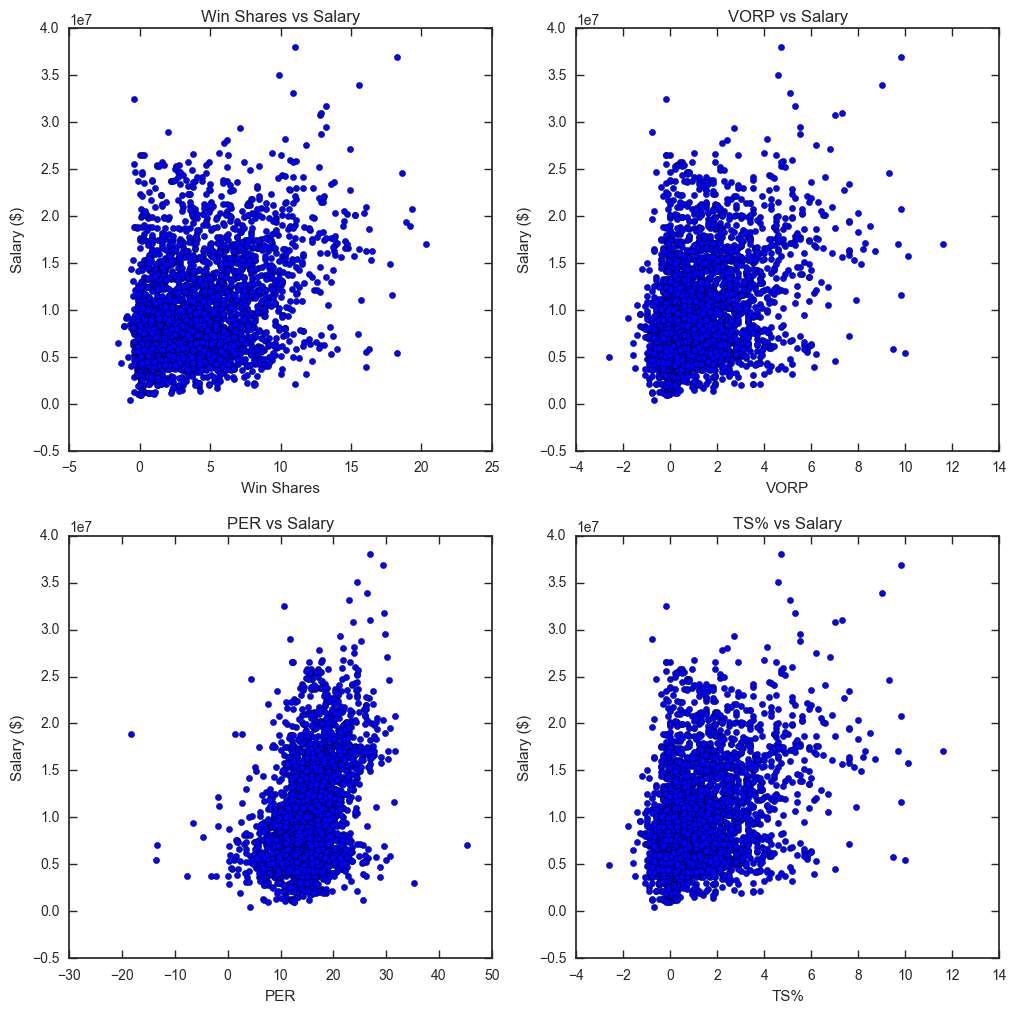

In [552]:
df_final = pd.read_csv('data/merged_df.csv')

fig, ax = plt.subplots(2,2, figsize=(12,12))

# Win Shares vs Salary
WS_list = df_final['WS'].tolist()
salary_list = df_final['salary_adj'].tolist()

ax[0,0].scatter(WS_list, salary_list)
ax[0,0].set_title('Win Shares vs Salary')
ax[0,0].set_xlabel('Win Shares')
ax[0,0].set_ylabel('Salary ($)')

# VORP vs Salary
VORP_list = df_final['VORP'].tolist()
salary_list = df_final['salary_adj'].tolist()

ax[0,1].scatter(VORP_list, salary_list)
ax[0,1].set_title('VORP vs Salary')
ax[0,1].set_xlabel('VORP')
ax[0,1].set_ylabel('Salary ($)')

# PER vs Salary
PER_list = df_final['PER'].tolist()
salary_list = df_final['salary_adj'].tolist()

ax[1,0].scatter(PER_list, salary_list)
ax[1,0].set_title('PER vs Salary')
ax[1,0].set_xlabel('PER')
ax[1,0].set_ylabel('Salary ($)')

# TS% vs Salary
TS_list = df_final['TS%'].tolist()
salary_list = df_final['salary_adj'].tolist()

ax[1,1].scatter(VORP_list, salary_list)
ax[1,1].set_title('TS% vs Salary')
ax[1,1].set_xlabel('TS%')
ax[1,1].set_ylabel('Salary ($)')

# Cross-Validation

### Visualization

In [553]:
complete_X_cols = ['Age', 'G', 'MP',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM',
       'BPM', 'VORP', '2P', '2P%', '2PA', '3P', '3P%', '3PA', 'AST', 'BLK',
       'DRB', 'FG', 'FG%', 'FGA', 'FT', 'FT%', 'FTA', 'GS', 'ORB', 'PF', 'PTS',
       'STL', 'TOV', 'TRB', 'eFG%', 'Pos_C', 'Pos_PF', 'Pos_PG', 'Pos_SF',
       'Pos_SG']


# Separate the column names into % and total counts and further separate into offensive and defensive stats
# Will also have a list of advanced metrics
# Also, columns that are relatively irrelevant such as GS (Games started) and FTA/FT, 2PA/2P will be excluded
off_perc_cols = ['salary_adj','TS%', 'AST%', 'TOV%','FG%','eFG%','ORB%']
off_sh_perc_cols = ['salary_adj','2P%','3P%','FT%']
off_count_cols = ['salary_adj','AST','TOV','ORB', 'PTS']

def_perc_cols = ['salary_adj','DRB%','STL%']
def_count_cols = ['salary_adj','DRB','STL']

adv_cols = ['salary_adj','PER','OWS','DWS','WS','WS/48','BPM']

common_cols = ['salary_adj','Age','PTS','AST','TRB','BLK','STL','TOV']

#### Common stats pair plot

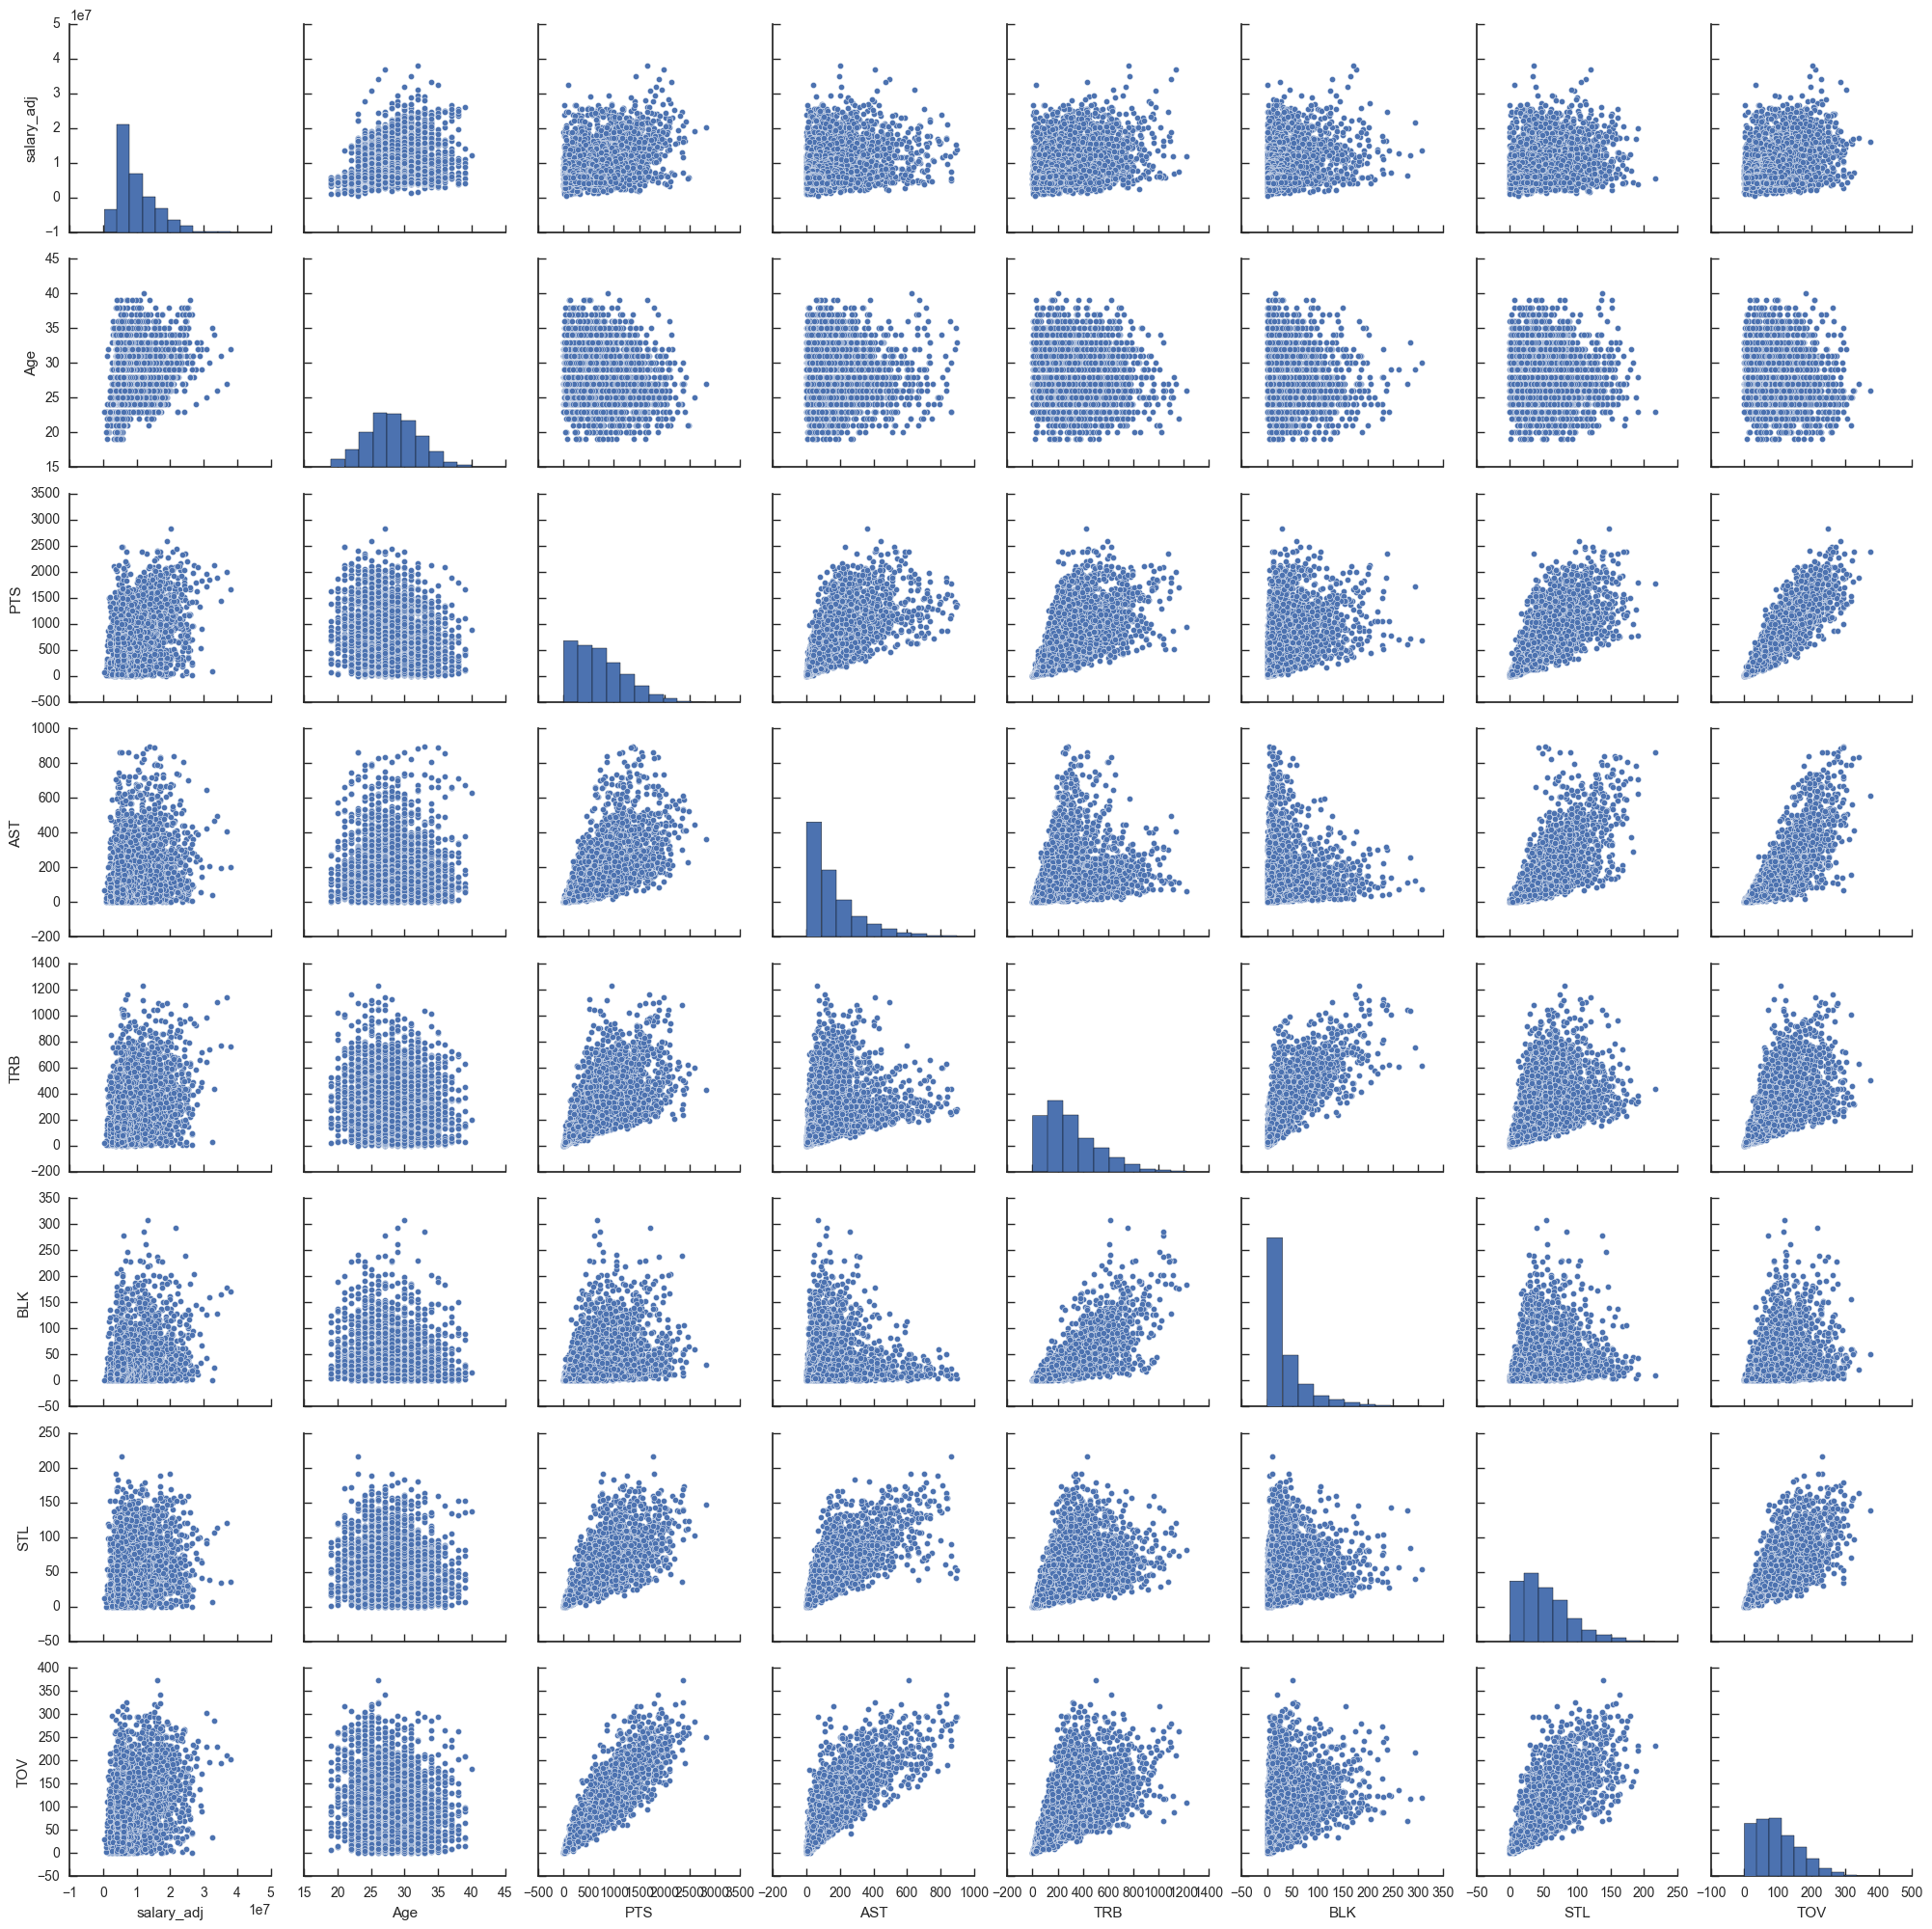

In [554]:
df_plot1 = df_final.loc[:,common_cols]

sns.pairplot(df_plot1)

#### Advanced stats pair plot

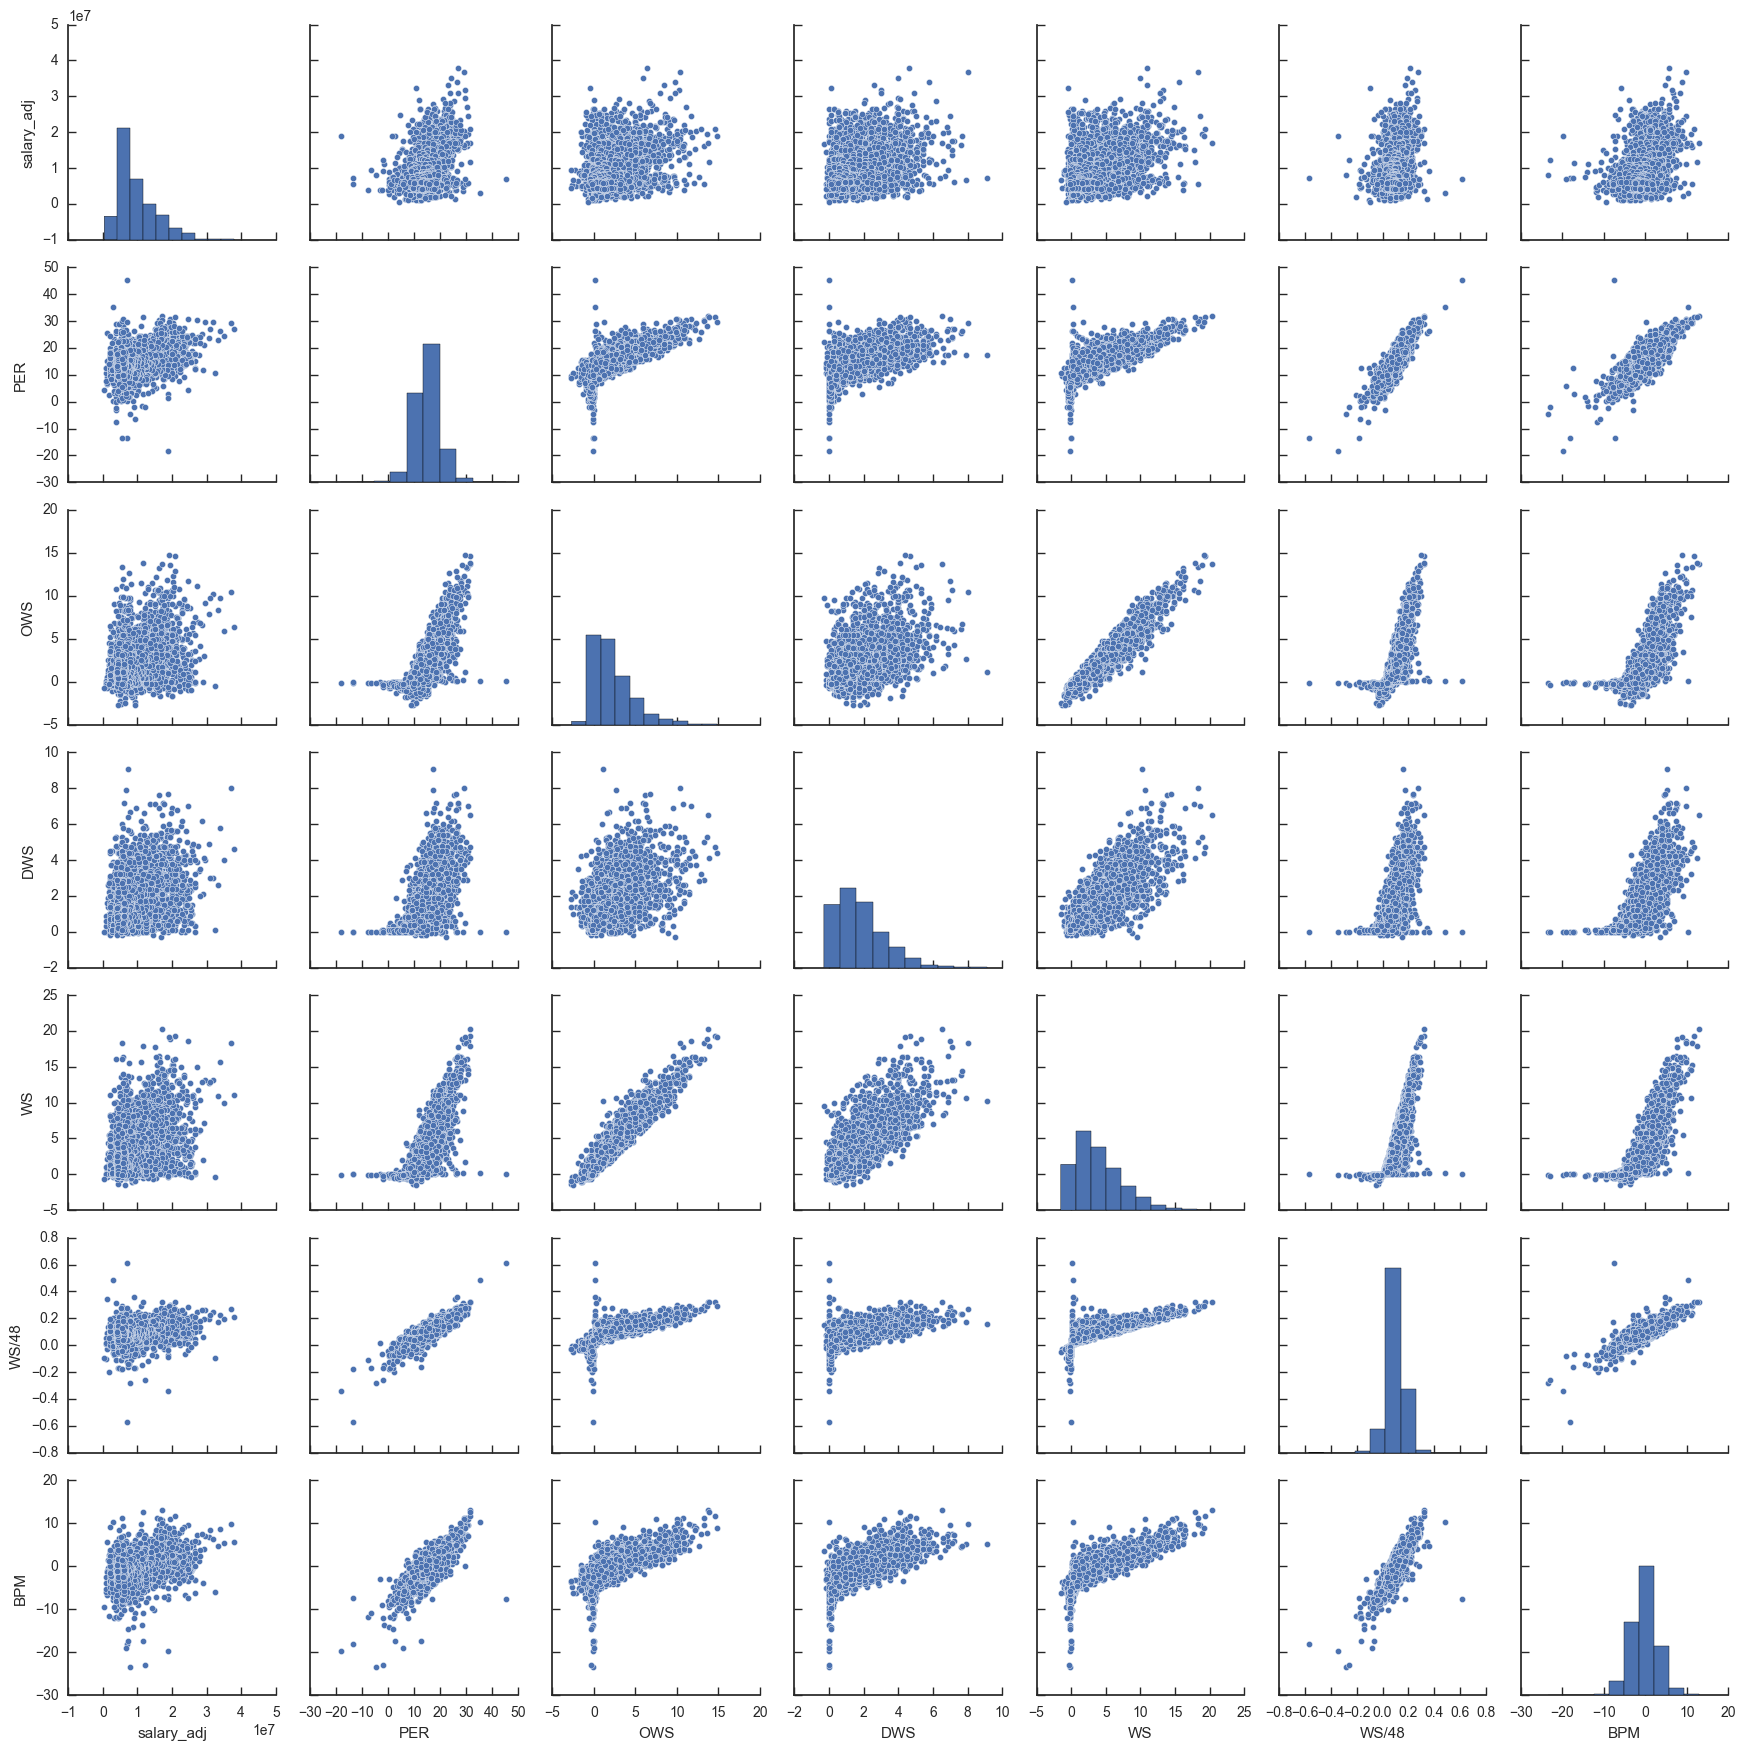

In [555]:
df_plot2 = df_final.loc[:,adv_cols]

sns.pairplot(df_plot2)

#### Offensive percentage stats pair plot

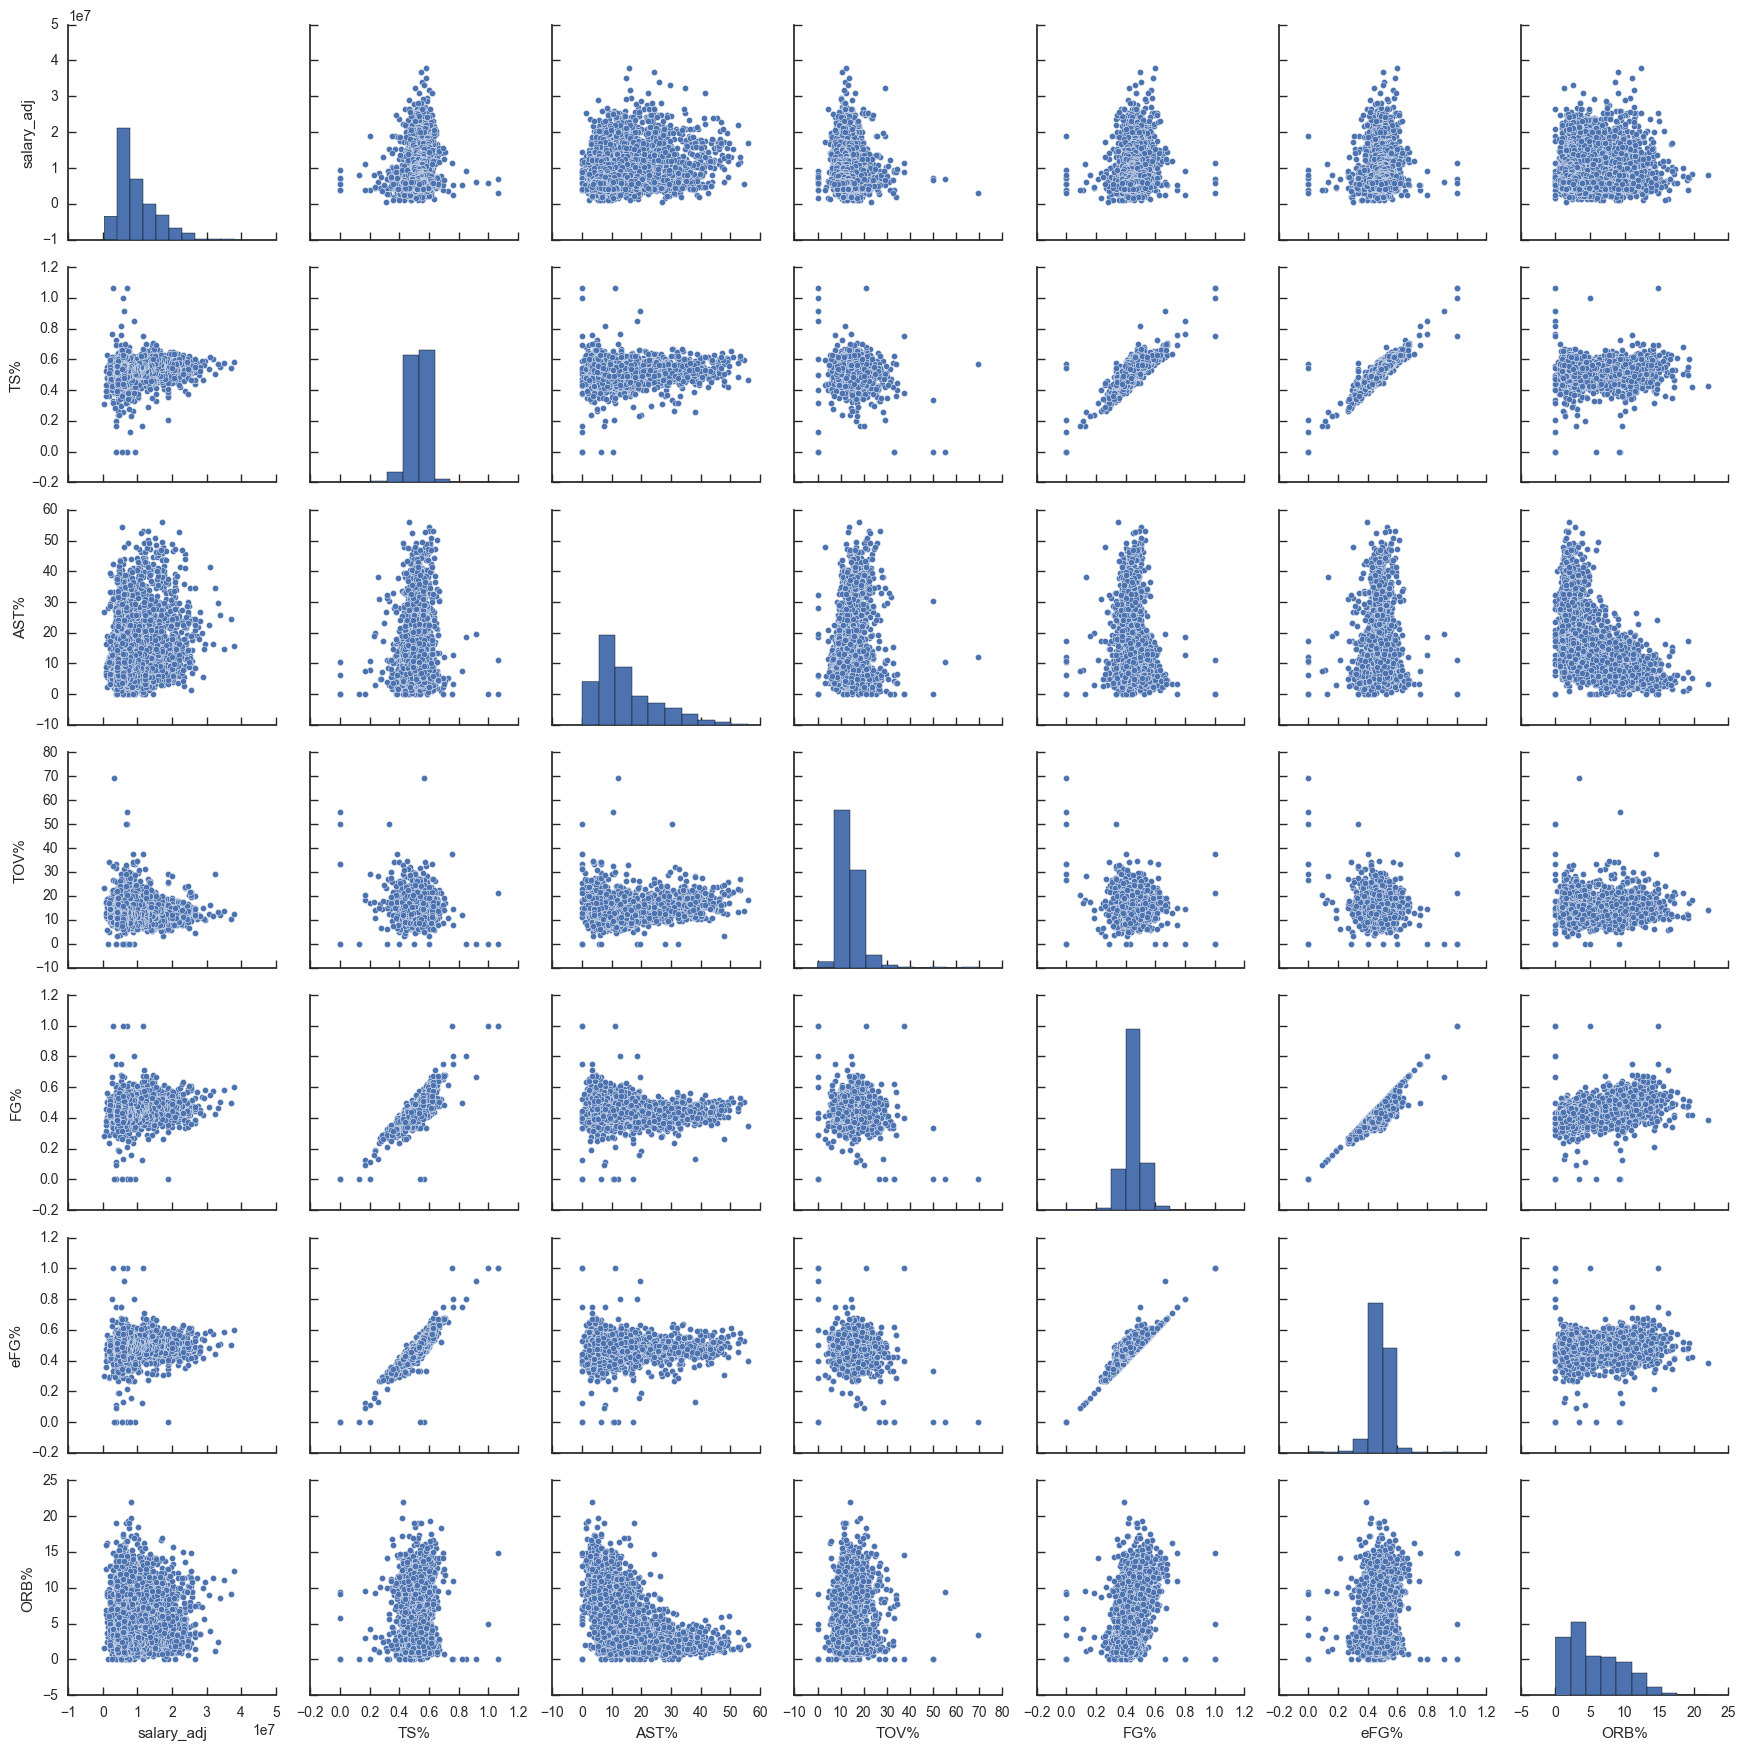

In [556]:
df_plot3 = df_final.loc[:,off_perc_cols]

sns.pairplot(df_plot3)

#### Offensive count stats pair plot

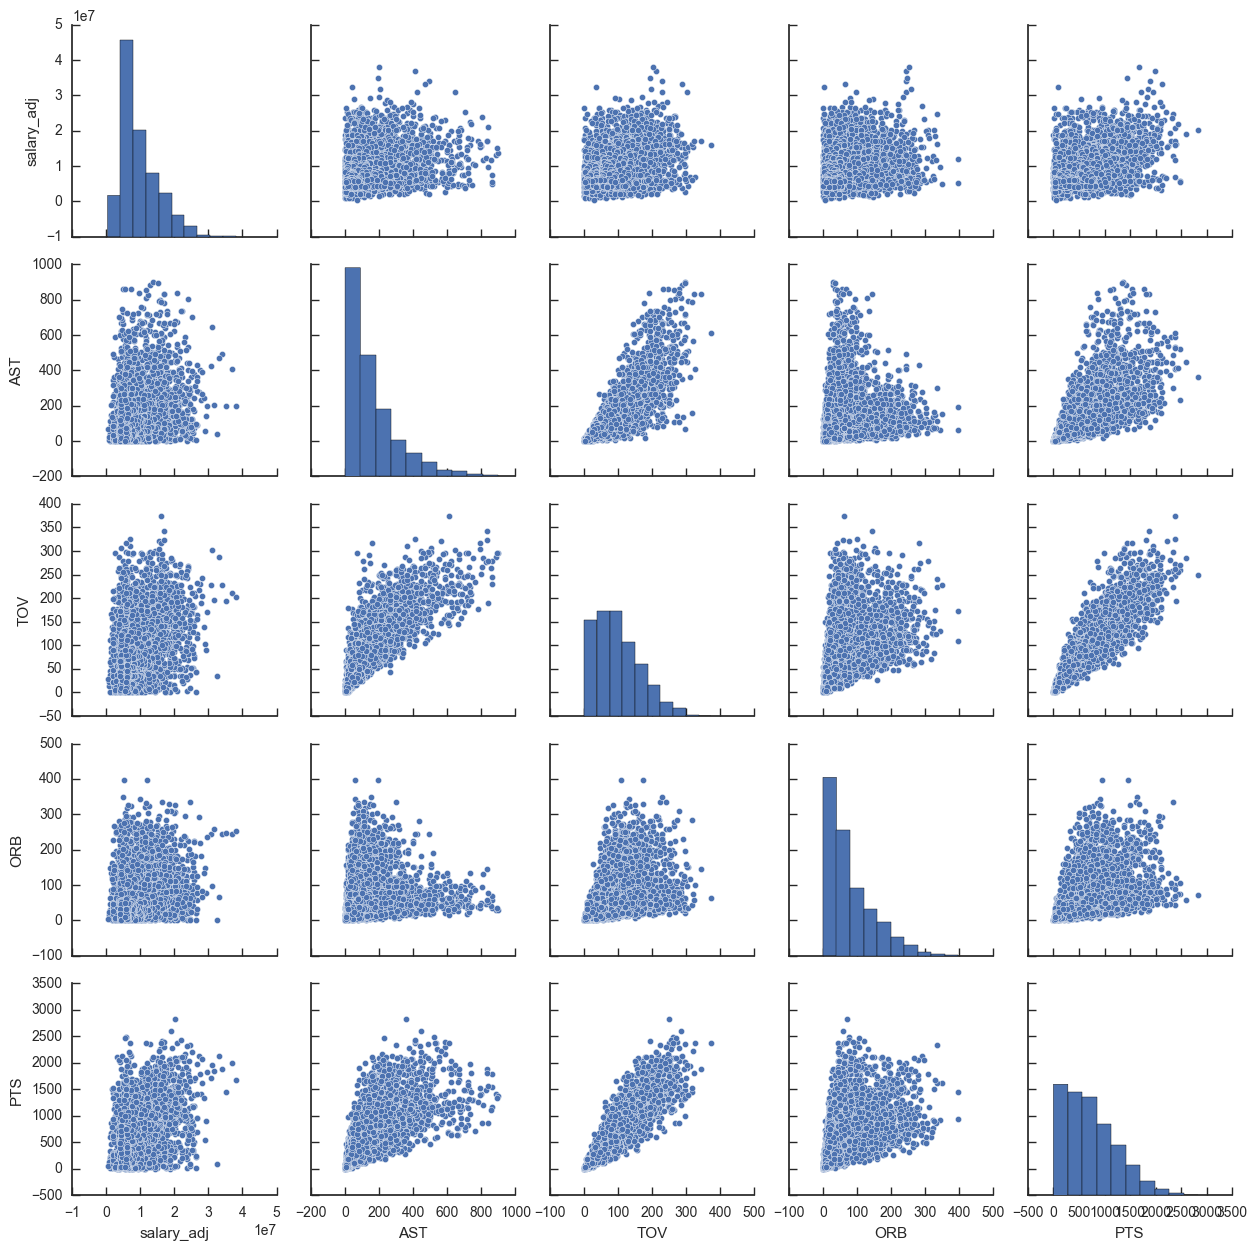

In [557]:
df_plot4 = df_final.loc[:,off_count_cols]

sns.pairplot(df_plot4)

#### Offensive shooting percentage pair plot

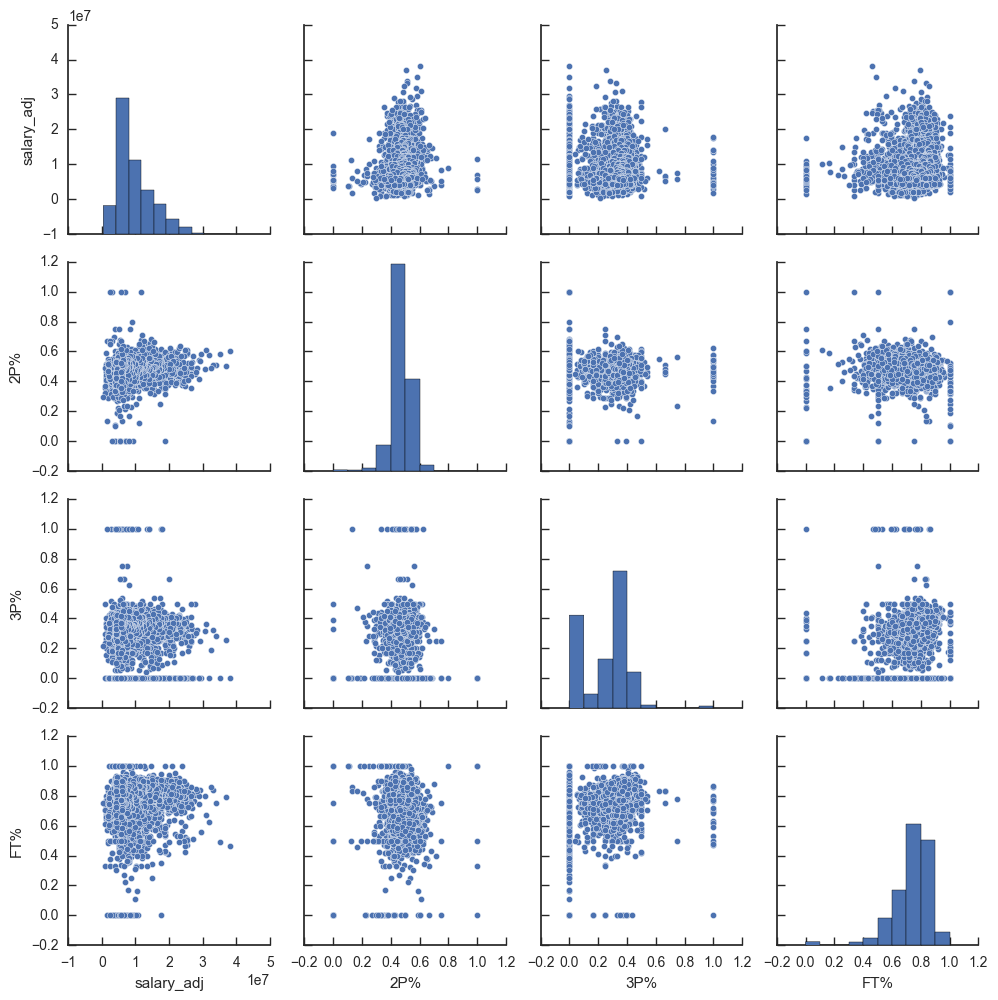

In [558]:
df_plot5 = df_final.loc[:,off_sh_perc_cols]

sns.pairplot(df_plot5)

#### Defensive percentage stats pair plot

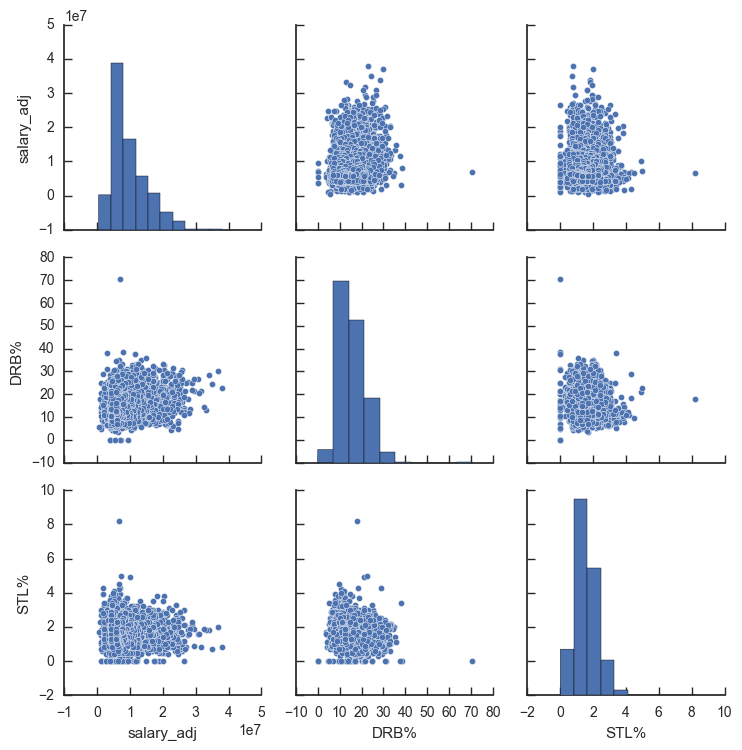

In [559]:
df_plot6 = df_final.loc[:,def_perc_cols]

sns.pairplot(df_plot6)

#### Defensive count stats pair plot

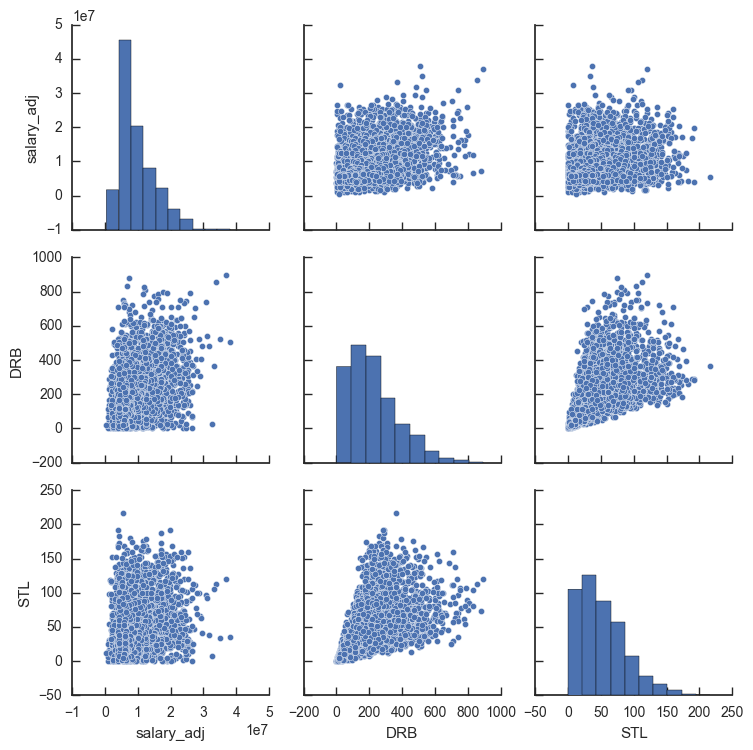

In [560]:
df_plot7 = df_final.loc[:,def_count_cols]

sns.pairplot(df_plot7)

### Starting with linear regression.

In [659]:
# First need to shuffle the dataframe to remove any ordering.
df_test = df_final.sample(frac=1)

In [716]:
# Square PER, AGE, GS, G, USG%
df_test2 = square_features(df_test, ['PER','Age','GS','G','USG%'])

# Cube Age, G, USG%
df_test3 = cube_features(df_test2, ['Age','G','USG%'])

# Create ratios: PTS/TOV, AST/TOV, STL/TOV, BLK/TRB, STL/AST
df_test3['PTS/TOV'] = (df_test3['PTS']/df_test3['TOV']).replace([np.inf, -np.inf], np.nan).fillna(value=0)
df_test3['AST/TOV'] = (df_test3['AST']/df_test3['TOV']).replace([np.inf, -np.inf], np.nan).fillna(value=0)
df_test3['STL/TOV'] = (df_test3['STL']/df_test3['TOV']).replace([np.inf, -np.inf], np.nan).fillna(value=0)
df_test3['BLK/TRB'] = (df_test3['BLK']/df_test3['TRB']).replace([np.inf, -np.inf], np.nan).fillna(value=0)
df_test3['STL/AST'] = (df_test3['STL']/df_test3['AST']).replace([np.inf, -np.inf], np.nan).fillna(value=0)



# Create ratios: WS/PER, OWS/PER, WS/OWS, BPM/OWS, BPM/WSper48
df_test3['WS/PER'] = (df_test3['WS']/df_test3['PER']).replace([np.inf, -np.inf], np.nan).fillna(value=0)
df_test3['OWS/PER'] = (df_test3['OWS']/df_test3['PER']).replace([np.inf, -np.inf], np.nan).fillna(value=0)
df_test3['WS/OWS'] = (df_test3['WS']/df_test3['OWS']).replace([np.inf, -np.inf], np.nan).fillna(value=0)
df_test3['BPM/OWS'] = (df_test3['BPM']/df_test3['OWS']).replace([np.inf, -np.inf], np.nan).fillna(value=0)
df_test3['BPM/WSper48'] = (df_test3['BPM']/df_test3['WS/48']).replace([np.inf, -np.inf], np.nan).fillna(value=0)

# Create features that will rank players in each team and each year.
rank_col_list = ['PTS','AST','TRB','BLK','STL','TOV','MP','WS','PER']
group_col_list = ['Yr','Tm']

df_ranked = rank_features(df_test3, group_col_list, rank_col_list)
df_test4 = df_test3.merge(df_ranked, left_index=True, right_index=True)


# Change target feature to log(salary_adj)
df_test4['salary_adj_ln'] = df_test4['salary_adj'].apply(np.log)

X_cols = ['Age', 'G',
       'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', '2P', '2P%', '2PA', '3P', '3P%', '3PA', 'AST',
       'BLK', 'DRB', 'FG', 'FG%', 'FGA', 'FT', 'FT%', 'FTA', 'GS', 'ORB', 'PF',
       'PTS', 'STL', 'TOV', 'TRB', 'eFG%', 'Pos_C', 'Pos_PF', 'Pos_PG',
       'Pos_SF', 'Pos_SG', 'PER_sq', 'Age_sq', 'GS_sq', 'G_sq', 'USG%_sq',
       'Age_cube', 'G_cube', 'USG%_cube', 'PTS/TOV', 'AST/TOV', 'STL/TOV',
       'BLK/TRB', 'STL/AST', 'WS/PER', 'OWS/PER', 'WS/OWS', 'BPM/OWS',
       'BPM/WSper48', 'PTS_rk', 'AST_rk', 'TRB_rk', 'BLK_rk', 'STL_rk',
       'TOV_rk', 'MP_rk','WS_rk','PER_rk']

# Create the X and y matrices. 
# Also, set apart 15% of the data for a holdout set.
holdout = df_test4.iloc[0:403, :]

df_test5 = df_test4.iloc[403:,:]

X = df_test4.iloc[403:,:]
X = X.loc[:, X_cols]
y = df_test4.iloc[403:,:]
y = y.loc[:, 'salary_adj']

X_arr = X.as_matrix()
y_arr = y.as_matrix()

# df_test2.min()
# df_test2.columns

In [714]:
reg = linear_model.LinearRegression()
scores = cross_val_score(reg, X, y, cv=10, scoring='r2')
print(scores.mean())

0.462461463362


## Move on to ridge, lasso, and elastic.

In [564]:
models = {}
models['LinReg'] = linear_model.LinearRegression()
models['Ridge'] = linear_model.Ridge()
models['Lasso_2'] = linear_model.Lasso(alpha=2)
models['Lasso_02'] = linear_model.Lasso(alpha=.2)
models['Lasso_002'] = linear_model.Lasso(alpha=.02)
models['Lasso_20'] = linear_model.Lasso(alpha=20)
models['Lasso_200'] = linear_model.Lasso(alpha=200)
models['Lasso_2000'] = linear_model.Lasso(alpha=2000)
models['Lasso_20000'] = linear_model.Lasso(alpha=20000)
models['ElasticNet_2'] = linear_model.ElasticNet(alpha=2)
models['ElasticNet_20'] = linear_model.ElasticNet(alpha=20)
models['ElasticNet_200'] = linear_model.ElasticNet(alpha=200)
models['ElasticNet_2000'] = linear_model.ElasticNet(alpha=2000)
models['ElasticNet_20000'] = linear_model.ElasticNet(alpha=20000)
models['DecisionTree'] = tree.DecisionTreeRegressor(max_depth=5, min_samples_split=5)

### Score the models and compare to the training set

In [565]:
model_list = fit_models(models, df_test5, X_cols, 'salary_adj')

Model: DecisionTree
Test Score: 0.301973306483 with STD: 0.0207262110542
Train Score: 0.447186007771 with STD: 0.00784222087559
Model: ElasticNet_2
Test Score: 0.454312600443 with STD: 0.0233637579688
Train Score: 0.473084851138 with STD: 0.00595454771494
Model: ElasticNet_20
Test Score: 0.447571330801 with STD: 0.0238606014862
Train Score: 0.462261712485 with STD: 0.00597580840328
Model: ElasticNet_200
Test Score: 0.43646368977 with STD: 0.0268675580896
Train Score: 0.448486405786 with STD: 0.00665862786102
Model: ElasticNet_2000
Test Score: 0.409504963228 with STD: 0.0308367353842
Train Score: 0.419296370553 with STD: 0.00807562211757
Model: ElasticNet_20000
Test Score: 0.386099768927 with STD: 0.0319888249152
Train Score: 0.393772950839 with STD: 0.00916007970018
Model: Lasso_002
Test Score: 0.462972221512 with STD: 0.0231846594243
Train Score: 0.494122452059 with STD: 0.00566389914977
Model: Lasso_02
Test Score: 0.462972579202 with STD: 0.0231844348391
Train Score: 0.494122447046 w

In [566]:
sorted(zip(abs(model_list['Lasso_20'][0].coef_), X_cols),reverse=True)

[(34472951.155682348, 'FG%'),
 (21315734.920162283, 'eFG%'),
 (12162529.330466356, 'WS/48'),
 (8276925.6333117066, 'TS%'),
 (3506261.7399080694, 'BLK/TRB'),
 (2875310.0165659669, '2P%'),
 (2788817.176452104, '3PAr'),
 (2550702.5525283758, 'FTr'),
 (2081176.4751182264, 'FT%'),
 (2021620.4923619896, 'Age'),
 (1745826.6985321604, 'Pos_PG'),
 (1378156.0643282533, 'TRB%'),
 (997559.69543982565, 'VORP'),
 (944292.23871366237, 'Pos_PF'),
 (934185.5470358032, 'Pos_C'),
 (851501.10879426717, 'ORB%'),
 (850353.34887696092, 'BPM'),
 (847871.46225738851, 'STL%'),
 (796756.48127034551, 'STL/AST'),
 (702335.47838538361, 'DWS'),
 (619872.61400288285, 'STL/TOV'),
 (580973.36965879158, 'AST/TOV'),
 (577893.69369125436, 'DRB%'),
 (430649.31826456758, 'Pos_SF'),
 (384154.18805389717, '3P%'),
 (327971.70449627034, 'OWS'),
 (255581.24206301488, 'OBPM'),
 (237813.01972776849, 'WS'),
 (226134.81487590008, 'WS_rk'),
 (213020.96518572152, 'PER'),
 (210676.05584017743, 'DBPM'),
 (128619.60810777594, 'STL_rk'),


### Try different list of features

In [570]:
# Attempt 1: PER, VORP, BPM
att_1 = ['PER','VORP','BPM']

model_list_1 = fit_models(models, df_test5, att_1, 'salary_adj')

Model: DecisionTree
Test Score: 0.166888231445 with STD: 0.0156002981668
Train Score: 0.26712105993 with STD: 0.0108065374513
Model: ElasticNet_2
Test Score: 0.180684221451 with STD: 0.0124449066423
Train Score: 0.184866695379 with STD: 0.00469498948672
Model: ElasticNet_20
Test Score: 0.160858735517 with STD: 0.00756437564333
Train Score: 0.163855312699 with STD: 0.00344119898155
Model: ElasticNet_200
Test Score: 0.0720233686802 with STD: 0.00420507901255
Train Score: 0.0746960203242 with STD: 0.00203737171559
Model: ElasticNet_2000
Test Score: 0.00806578557364 with STD: 0.00355767112258
Train Score: 0.0108274493677 with STD: 0.000351769207904
Model: ElasticNet_20000
Test Score: -0.00164743031106 with STD: 0.00348239528366
Train Score: 0.00113022457389 with STD: 3.7622141963e-05
Model: Lasso_002
Test Score: 0.187474756567 with STD: 0.0180282360539
Train Score: 0.192973256569 with STD: 0.00542320973305
Model: Lasso_02
Test Score: 0.187474757299 with STD: 0.0180282317265
Train Score: 0.

In [571]:
# Attempt 2: PTS, AST, TRB, STL, BLK
att_2 = ['PTS','AST','TRB', 'STL', 'BLK']

model_list_2 = fit_models(models, df_test5, att_2, 'salary_adj')

Model: DecisionTree
Test Score: 0.096840245145 with STD: 0.0342863738852
Train Score: 0.260804170699 with STD: 0.0127820959047
Model: ElasticNet_2
Test Score: 0.177050745627 with STD: 0.0309616671247
Train Score: 0.183641262475 with STD: 0.0082339395323
Model: ElasticNet_20
Test Score: 0.17708085524 with STD: 0.0307340337771
Train Score: 0.183629032122 with STD: 0.00823283583646
Model: ElasticNet_200
Test Score: 0.176555484898 with STD: 0.02905460739
Train Score: 0.182783016969 with STD: 0.00815956902169
Model: ElasticNet_2000
Test Score: 0.165929845213 with STD: 0.0256486741862
Train Score: 0.171407889383 with STD: 0.00736235395135
Model: ElasticNet_20000
Test Score: 0.154664995358 with STD: 0.0238826693528
Train Score: 0.159540908197 with STD: 0.00684726717241
Model: Lasso_002
Test Score: 0.177046019603 with STD: 0.0309878448094
Train Score: 0.183641391172 with STD: 0.00823395119886
Model: Lasso_02
Test Score: 0.177046019621 with STD: 0.0309878446629
Train Score: 0.183641391172 with 

In [572]:
# Attempt 3: PTS, AST, TRB, PER, VORP, BPM
att_3 = ['PTS','AST','TRB', 'PER','VORP','BPM']

model_list_3 = fit_models(models, df_test5, att_3, 'salary_adj')

Model: DecisionTree
Test Score: 0.148803945592 with STD: 0.0505776246026
Train Score: 0.281202034666 with STD: 0.00843980051884
Model: ElasticNet_2
Test Score: 0.188067432773 with STD: 0.0206685147436
Train Score: 0.194054503686 with STD: 0.00606351880353
Model: ElasticNet_20
Test Score: 0.178348435729 with STD: 0.0220918629711
Train Score: 0.183721290094 with STD: 0.00593839218601
Model: ElasticNet_200
Test Score: 0.159580620108 with STD: 0.0241971070782
Train Score: 0.164878339456 with STD: 0.00650932115771
Model: ElasticNet_2000
Test Score: 0.153390341614 with STD: 0.0246463765002
Train Score: 0.158634760116 with STD: 0.0066903231495
Model: ElasticNet_20000
Test Score: 0.152639064569 with STD: 0.0237524011321
Train Score: 0.157461840014 with STD: 0.00674649067372
Model: Lasso_002
Test Score: 0.191997820504 with STD: 0.02210148143
Train Score: 0.198880029319 with STD: 0.00642506826809
Model: Lasso_02
Test Score: 0.191997821263 with STD: 0.0221014789772
Train Score: 0.198880029319 wit

In [573]:
# Attempt 4: All but eFG%, WS/48, WS, TS%, Pos_SG, Pos_SF, FG%, 2P%
df_att4 = square_features(df_test5, ['PTS','AST','TRB', 'STL', 'BLK'])
att_4 = ['Age', 'G',
       'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', '2P', '2P%', '2PA', '3P', '3P%', '3PA', 'AST',
       'BLK', 'DRB', 'FG', 'FG%', 'FGA', 'FT', 'FT%', 'FTA', 'GS', 'ORB', 'PF',
       'PTS', 'STL', 'TOV', 'TRB', 'eFG%', 'Pos_C', 'Pos_PF', 'Pos_PG',
       'Pos_SF', 'Pos_SG', 'PER_sq', 'Age_sq', 'GS_sq', 'G_sq', 'USG%_sq',
       'Age_cube', 'G_cube', 'USG%_cube', 'PTS/TOV', 'AST/TOV', 'STL/TOV',
       'BLK/TRB', 'STL/AST', 'WS/PER', 'OWS/PER', 'WS/OWS', 'BPM/OWS',
       'BPM/WSper48', 'PTS_rk', 'AST_rk', 'TRB_rk', 'BLK_rk', 'STL_rk',
       'TOV_rk', 'MP_rk']

model_list_4 = fit_models(models, df_att4, att_4, 'salary_adj')
sorted(zip(abs(model_list_4['Lasso_2'][0].coef_),att_4),reverse=True)

Model: DecisionTree
Test Score: 0.301973306483 with STD: 0.0207262110542
Train Score: 0.447186007771 with STD: 0.00784222087559
Model: ElasticNet_2
Test Score: 0.452906020628 with STD: 0.0231209931806
Train Score: 0.471208229579 with STD: 0.00585091826418
Model: ElasticNet_20
Test Score: 0.447281497159 with STD: 0.023827048409
Train Score: 0.461749562368 with STD: 0.00594420654762
Model: ElasticNet_200
Test Score: 0.436566943346 with STD: 0.0268801775525
Train Score: 0.448467224512 with STD: 0.00665693313517
Model: ElasticNet_2000
Test Score: 0.409516849175 with STD: 0.0308451615771
Train Score: 0.419286195516 with STD: 0.00808022427115
Model: ElasticNet_20000
Test Score: 0.386100397764 with STD: 0.0319901525958
Train Score: 0.393771274928 with STD: 0.00916086413224
Model: Lasso_002
Test Score: 0.46176774624 with STD: 0.0226969560817
Train Score: 0.492270756143 with STD: 0.0054066862299
Model: Lasso_02
Test Score: 0.461768015359 with STD: 0.0226967496933
Train Score: 0.492270747746 wit

[(37847155.74398613, 'FG%'),
 (23753072.567126464, 'eFG%'),
 (11798275.406954922, 'WS/48'),
 (8473269.9524785802, 'TS%'),
 (4181019.4488711767, 'BLK/TRB'),
 (3236862.4209178751, '2P%'),
 (3232564.3645875077, '3PAr'),
 (2563696.1144053433, 'FTr'),
 (2234244.1322614253, 'WS/PER'),
 (2054656.7894621827, 'FT%'),
 (2022202.8428914812, 'Age'),
 (1631776.7895898018, 'Pos_PG'),
 (1481280.2283390292, 'TRB%'),
 (1266039.3905594116, 'OWS/PER'),
 (1021502.9793326419, 'Pos_PF'),
 (997769.84043542715, 'VORP'),
 (985014.66022255563, 'Pos_C'),
 (898064.73707175744, 'ORB%'),
 (854752.37101632846, 'STL%'),
 (838365.73818050162, 'DWS'),
 (822680.11436453124, 'BPM'),
 (770659.56166365347, 'STL/AST'),
 (627041.49451029918, 'DRB%'),
 (578192.49809499318, 'AST/TOV'),
 (543619.04570198862, 'STL/TOV'),
 (540167.33963607741, 'Pos_SF'),
 (431405.30883332953, '3P%'),
 (363257.90484285419, 'OWS'),
 (267243.86370952229, 'WS'),
 (265957.4798585723, 'PER'),
 (221575.59420048282, 'OBPM'),
 (164054.65935808804, 'DBPM')

## Random Forest Regression

In [717]:
# Create 5 random, noisy features to see if there are any features that perform worse than these random features
rand_col_names = ['RAND_1','RAND_2','RAND_3','RAND_4','RAND_5']
df_rf = rand_features(df_test5, rand_col_names)

In [577]:
rf_dict = {}
rf_dict['RF_10'] = RandomForestRegressor(n_estimators=10, max_features='auto', min_samples_split=10)
rf_dict['RF_30'] = RandomForestRegressor(n_estimators=30, max_features='auto', min_samples_split=10)
rf_dict['RF_50'] = RandomForestRegressor(n_estimators=50, max_features='auto', min_samples_split=10)
rf_dict['RF_100'] = RandomForestRegressor(n_estimators=100, max_features='auto', min_samples_split=10)


In [719]:
rf_cols = ['Age', 'G',
       'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', '2P', '2P%', '2PA', '3P', '3P%', '3PA', 'AST',
       'BLK', 'DRB', 'FG', 'FG%', 'FGA', 'FT', 'FT%', 'FTA', 'GS', 'ORB', 'PF',
       'PTS', 'STL', 'TOV', 'TRB', 'eFG%', 'Pos_C', 'Pos_PF', 'Pos_PG',
       'Pos_SF', 'Pos_SG', 'PER_sq', 'Age_sq', 'GS_sq', 'G_sq', 'USG%_sq',
       'Age_cube', 'G_cube', 'USG%_cube', 'PTS/TOV', 'AST/TOV', 'STL/TOV',
       'BLK/TRB', 'STL/AST', 'WS/PER', 'OWS/PER', 'WS/OWS', 'BPM/OWS',
       'BPM/WSper48', 'PTS_rk', 'AST_rk', 'TRB_rk', 'BLK_rk', 'STL_rk',
       'TOV_rk', 'MP_rk',
       'RAND_1','RAND_2','RAND_3','RAND_4','RAND_5']
rf_scores = fit_models(rf_dict, df_rf, rf_cols, 'salary_adj')

Model: RF_10
Test Score: 0.423355861395 with STD: 0.031761143426
Train Score: 0.837190346205 with STD: 0.00488375459282
Model: RF_100
Test Score: 0.473236223245 with STD: 0.0365973916248
Train Score: 0.868772740651 with STD: 0.00378535015176
Model: RF_30
Test Score: 0.454862317355 with STD: 0.0404935398808
Train Score: 0.861460597264 with STD: 0.00329254763495
Model: RF_50
Test Score: 0.466571256858 with STD: 0.0386482494542
Train Score: 0.865840180046 with STD: 0.00307648311308


In [582]:
mean_fi = rf_scores['RF_100'][0].feature_importances_
list_means = sorted(zip(mean_fi,rf_cols),reverse=True)

In [580]:
rf_cols = ['PER_sq', 'PER', 'Age_sq', 'USG%', 'Age', 'GS', 'DRB%', 'GS_sq', 'G', 'RAND_4']
rf_scores2 = fit_models(rf_dict, df_rf, rf_cols, 'salary_adj')

Model: RF_10
Test Score: 0.397302931845 with STD: 0.0238359625182
Train Score: 0.783754569516 with STD: 0.00414293492152
Model: RF_100
Test Score: 0.44596978203 with STD: 0.0279869937076
Train Score: 0.814153439666 with STD: 0.0023252973081
Model: RF_30
Test Score: 0.433685682187 with STD: 0.0274143323887
Train Score: 0.809281196813 with STD: 0.00464768331984
Model: RF_50
Test Score: 0.439198863396 with STD: 0.0230141062935
Train Score: 0.810817797738 with STD: 0.00371125766897


In [583]:
mean_fi2 = rf_scores2['RF_100'][0].feature_importances_
list_means2 = sorted(zip(mean_fi2,rf_cols),reverse=True)

## Gradient Boosting Regression

In [584]:
gb_cols = ['Age', 'G',
       'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', '2P', '2P%', '2PA', '3P', '3P%', '3PA', 'AST',
       'DRB', 'FG', 'FG%', 'FGA', 'FT', 'FT%', 'FTA', 'GS', 'ORB', 'PF',
       'eFG%', 'Pos_C', 'Pos_PF', 'Pos_PG',
       'Pos_SF', 'Pos_SG', 'PER_sq', 'Age_sq', 'GS_sq', 'G_sq', 'USG%_sq',
       'Age_cube', 'G_cube', 'USG%_cube', 'PTS/TOV', 'AST/TOV', 'STL/TOV',
       'BLK/TRB', 'STL/AST', 'WS/PER', 'OWS/PER', 'WS/OWS', 'BPM/OWS',
       'BPM/WSper48', 'PTS_rk', 'AST_rk', 'TRB_rk', 'BLK_rk', 'STL_rk',
       'TOV_rk', 'MP_rk']

In [585]:
gb_dict = {}
gb_dict['GB_10'] = GradientBoostingRegressor(n_estimators=10)
gb_dict['GB_50'] = GradientBoostingRegressor(n_estimators=50)
gb_dict['GB_100'] = GradientBoostingRegressor(n_estimators=100)
gb_dict['GB_150'] = GradientBoostingRegressor(n_estimators=150)

In [586]:
gb_models_list = fit_models(gb_dict, df_rf, gb_cols, 'salary_adj')

Model: GB_10
Test Score: 0.298132327072 with STD: 0.0132265973676
Train Score: 0.337195368496 with STD: 0.00528168313216
Model: GB_100
Test Score: 0.486435743579 with STD: 0.0240096580348
Train Score: 0.659870057334 with STD: 0.00396097869222
Model: GB_150
Test Score: 0.493598014969 with STD: 0.0265842570508
Train Score: 0.713619753338 with STD: 0.00447660324045
Model: GB_50
Test Score: 0.457874651862 with STD: 0.0223295180735
Train Score: 0.576320975064 with STD: 0.00531804591446


## Use GridSearchCV to tune hyper parameters

### GradientBoostingRegressor tuning

In [587]:
# X_cols_gb = ['Age','PTS','AST','TRB','BLK','STL','TOV','G','USG%','Age_sq']

X_gb = df_rf.loc[:, gb_cols]
y_gb = df_rf.loc[:, 'salary_adj']

X_train, X_test, y_train, y_test = train_test_split(X_gb, y_gb, test_size=0.2)

gb_parameters = {'n_estimators': [10,50,100,200,400], 
                 'max_depth': [2,3,4,5,6], 
                 'min_samples_split': [5,10,20,40,60],
                 'max_features': ['sqrt', 'auto']}

In [720]:
clf = GridSearchCV(GradientBoostingRegressor(), param_grid=gb_parameters, n_jobs=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'min_samples_split': [5, 10, 20, 40, 60], 'max_features': ['sqrt', 'auto'], 'n_estimators': [10, 50, 100, 200, 400], 'max_depth': [2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [721]:
print('Best Parameters: ', clf.best_params_)
print('Best Score: ', clf.best_score_)

Best Parameters:  {'min_samples_split': 40, 'max_features': 'auto', 'n_estimators': 200, 'max_depth': 5}
Best Score:  0.483311820531


In [722]:
best_gb = GradientBoostingRegressor(n_estimators=200, min_samples_split=40, max_features='auto', max_depth=5)
best_gb.fit(X_train, y_train)
train_score = best_gb.score(X_train, y_train)
test_score = best_gb.score(X_test, y_test)
print('Train Score: ', train_score)
print('Test Score: ', test_score)

Train Score:  0.902270001133
Test Score:  0.537489798336


In [596]:
sorted(zip(best_gb.feature_importances_, X_train.columns), reverse=True)

[(0.039591964266754334, 'PF'),
 (0.036904040948152514, 'BLK/TRB'),
 (0.027450275754824966, 'BPM/WSper48'),
 (0.026579015252414028, 'STL/TOV'),
 (0.024208946014144167, 'OWS/PER'),
 (0.023830297047442502, 'FTr'),
 (0.023667157704316003, 'PTS/TOV'),
 (0.02311186653928507, 'AST/TOV'),
 (0.022150076098288632, 'WS/PER'),
 (0.021691898910893431, 'STL/AST'),
 (0.020702083606391634, '3PAr'),
 (0.020567515659147245, 'BPM/OWS'),
 (0.020169871693378409, 'AST%'),
 (0.020006496367562659, 'FG%'),
 (0.019898540247184321, 'WS/OWS'),
 (0.018930304464926842, 'DRB%'),
 (0.018764544014936421, 'DRB'),
 (0.018546021666177633, 'Age_sq'),
 (0.018306882514983573, '3P%'),
 (0.018065812173700024, 'BLK%'),
 (0.017766683592077417, 'MP'),
 (0.017725562054051305, 'Age_cube'),
 (0.017265260286936358, 'PER_sq'),
 (0.016668403753945314, 'Age'),
 (0.015892945265110953, 'ORB'),
 (0.015763917098635363, 'FT%'),
 (0.015310745951352315, 'DBPM'),
 (0.014954305739262465, 'WS/48'),
 (0.014770568083530682, 'GS_sq'),
 (0.014691070

## Use recursive feature elimination

### GradientBoostingRegressor

In [723]:
# grad_cols = ['Age',
#        'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
#        'BLK%', 'TOV%', 'USG%', 'OWS', 'WS/48', 'OBPM',
#        'DBPM', 'BPM', '2P', '2P%', '2PA', '3P%', '3PA', 'AST',
#        'DRB', 'FG', 'FG%', 'FGA', 'FT', 'FT%', 'FTA', 'GS', 'ORB', 'PF',
#        'eFG%',
#        'PER_sq', 'GS_sq', 'G_sq', 'USG%_sq',
#        'Age_cube', 'G_cube', 'USG%_cube', 'PTS/TOV', 'AST/TOV', 'STL/TOV',
#        'BLK/TRB', 'STL/AST', 'WS/PER', 'OWS/PER', 'WS/OWS', 'BPM/OWS',
#        'BPM/WSper48']

# grad_cols = ['Age',
#        'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
#        'BLK%', 'TOV%', 'USG%', 'OWS', 'WS/48', 'OBPM',
#        'DBPM', 'BPM', '2P', '2P%', '2PA', '3P%', '3PA', 'AST',
#        'DRB', 'FG', 'FG%', 'FGA', 'FT', 'FT%', 'FTA', 'GS', 'ORB', 'PF',
#        'eFG%',
#        'PER_sq', 'GS_sq', 'G_sq', 'USG%_sq',
#        'Age_cube', 'G_cube',
#        'STL/AST', 'WS/PER', 'OWS/PER', 'WS/OWS', 'BPM/OWS',
#        'BPM/WSper48']

grad_cols = ['Age',
       'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'BLK%', 'TOV%', 'USG%', 'OWS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', '2P', '2P%', '2PA', '3P%', '3PA', 'AST',
       'DRB', 'FG', 'FG%', 'FGA', 'FT', 'FT%', 'FTA', 'GS', 'ORB', 'PF',
       'eFG%',
       'PER_sq', 'GS_sq', 'G_sq', 'USG%_sq',
       'Age_cube', 'G_cube']

X_gb2 = df_rf.loc[:, grad_cols]
y_gb2 = df_rf.loc[:, 'salary_adj']

X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_test_split(X_gb2, y_gb2, test_size=0.2)

rfecv_gb = RFECV(best_gb, n_jobs=3)
rfecv_gb.fit(X_train_gb, y_train_gb)

RFECV(cv=None,
   estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=40, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
   n_jobs=3, scoring=None, step=1, verbose=0)

In [724]:
rfecv_gb.score(X_test_gb, y_test_gb)

0.45314938288185624

In [725]:
sorted(zip(rfecv_gb.ranking_, grad_cols))

[(1, '2P%'),
 (1, '2PA'),
 (1, '3P%'),
 (1, '3PA'),
 (1, '3PAr'),
 (1, 'AST'),
 (1, 'AST%'),
 (1, 'Age'),
 (1, 'Age_cube'),
 (1, 'BLK%'),
 (1, 'BPM'),
 (1, 'DBPM'),
 (1, 'DRB'),
 (1, 'DRB%'),
 (1, 'FG'),
 (1, 'FG%'),
 (1, 'FT'),
 (1, 'FT%'),
 (1, 'FTr'),
 (1, 'GS'),
 (1, 'G_sq'),
 (1, 'MP'),
 (1, 'ORB%'),
 (1, 'OWS'),
 (1, 'PER_sq'),
 (1, 'PF'),
 (1, 'TOV%'),
 (1, 'TRB%'),
 (1, 'USG%'),
 (1, 'USG%_sq'),
 (1, 'WS/48'),
 (2, 'FGA'),
 (3, 'ORB'),
 (4, 'eFG%'),
 (5, '2P'),
 (6, 'G_cube'),
 (7, 'OBPM'),
 (8, 'TS%'),
 (9, 'FTA'),
 (10, 'PER'),
 (11, 'GS_sq')]

### Lasso

In [600]:
lasso_cols = ['Age', 'G',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', '2P', '2P%', '2PA', '3P', '3P%', '3PA', 'AST',
       'FG', 'FG%', 'FT', 'FTA', 'GS', 'ORB', 'PF',
       'Pos_PF',
       'Pos_SG', 'G_sq', 'USG%_sq',
       'Age_cube', 'G_cube', 'USG%_cube', 'PTS/TOV', 'AST/TOV', 'STL/TOV',
       'WS/PER', 'OWS/PER', 'WS/OWS', 'BPM/OWS',
       'BPM/WSper48', 'PTS_rk', 'AST_rk', 'TRB_rk', 'BLK_rk', 'STL_rk',
       'TOV_rk', 'MP_rk']

X_l = df_rf.loc[:, lasso_cols]
y_l = df_rf.loc[:, 'salary_adj']

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_l, y_l, test_size=0.2)
rfecv_lasso = RFECV(model_list_4['Lasso_200'][0], n_jobs=3)
rfecv_lasso.fit(X_train_l, y_train_l)

RFECV(cv=None,
   estimator=Lasso(alpha=200, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
   n_jobs=3, scoring=None, step=1, verbose=0)

In [601]:
rfecv_lasso.score(X_test_l, y_test_l)

0.45226919946481337

In [602]:
sorted(zip(rfecv_lasso.ranking_, lasso_cols))

[(1, '2P'),
 (1, '2P%'),
 (1, '2PA'),
 (1, '3P'),
 (1, '3P%'),
 (1, '3PA'),
 (1, '3PAr'),
 (1, 'AST'),
 (1, 'AST%'),
 (1, 'AST/TOV'),
 (1, 'AST_rk'),
 (1, 'Age'),
 (1, 'Age_cube'),
 (1, 'BLK%'),
 (1, 'BLK_rk'),
 (1, 'BPM'),
 (1, 'BPM/OWS'),
 (1, 'BPM/WSper48'),
 (1, 'DBPM'),
 (1, 'DRB%'),
 (1, 'DWS'),
 (1, 'FG'),
 (1, 'FG%'),
 (1, 'FT'),
 (1, 'FTA'),
 (1, 'FTr'),
 (1, 'G'),
 (1, 'GS'),
 (1, 'G_cube'),
 (1, 'G_sq'),
 (1, 'MP_rk'),
 (1, 'OBPM'),
 (1, 'ORB'),
 (1, 'ORB%'),
 (1, 'OWS'),
 (1, 'OWS/PER'),
 (1, 'PER'),
 (1, 'PF'),
 (1, 'PTS/TOV'),
 (1, 'PTS_rk'),
 (1, 'Pos_PF'),
 (1, 'Pos_SG'),
 (1, 'STL%'),
 (1, 'STL/TOV'),
 (1, 'STL_rk'),
 (1, 'TOV%'),
 (1, 'TOV_rk'),
 (1, 'TRB%'),
 (1, 'TRB_rk'),
 (1, 'TS%'),
 (1, 'USG%'),
 (1, 'USG%_cube'),
 (1, 'USG%_sq'),
 (1, 'VORP'),
 (1, 'WS'),
 (1, 'WS/48'),
 (1, 'WS/OWS'),
 (1, 'WS/PER')]

### RandomForestRegressor

In [748]:
rf_cols = ['Age', 'G',
       'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', '2P', '2P%', '2PA', '3P', '3P%', '3PA', 'AST',
       'BLK', 'DRB', 'FG', 'FG%', 'FGA', 'FT', 'FT%', 'FTA', 'GS', 'ORB', 'PF',
       'PTS', 'STL', 'TOV', 'TRB', 'eFG%', 'Pos_C', 'Pos_PF', 'Pos_PG',
       'Pos_SF', 'Pos_SG', 'PER_sq', 'Age_sq', 'GS_sq', 'G_sq', 'USG%_sq',
       'Age_cube', 'G_cube', 'USG%_cube', 'PTS/TOV', 'AST/TOV', 'STL/TOV',
       'BLK/TRB', 'STL/AST', 'WS/PER', 'OWS/PER', 'WS/OWS', 'BPM/OWS',
       'BPM/WSper48', 'PTS_rk', 'AST_rk', 'TRB_rk', 'BLK_rk', 'STL_rk',
       'TOV_rk', 'MP_rk','WS_rk','PER_rk']

X_rf = df_rf.loc[:, rf_cols]
y_rf = df_rf.loc[:, 'salary_adj']

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2)

rf_model = RandomForestRegressor(n_estimators=100, max_features='auto', min_samples_split=10)
rfecv_rf = RFECV(rf_model, n_jobs=3)
rfecv_rf.fit(X_train_rf, y_train_rf)

RFECV(cv=None,
   estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
   n_jobs=3, scoring=None, step=1, verbose=0)

In [604]:
rfecv_rf.score(X_test_rf, y_test_rf)

0.44036397704513353

In [605]:
sorted(zip(rfecv_rf.ranking_, rf_cols))

[(1, '2P'),
 (1, '2P%'),
 (1, '3P%'),
 (1, '3PA'),
 (1, '3PAr'),
 (1, 'AST'),
 (1, 'AST%'),
 (1, 'AST/TOV'),
 (1, 'Age'),
 (1, 'Age_cube'),
 (1, 'Age_sq'),
 (1, 'BLK'),
 (1, 'BLK%'),
 (1, 'BLK/TRB'),
 (1, 'BLK_rk'),
 (1, 'BPM'),
 (1, 'BPM/OWS'),
 (1, 'BPM/WSper48'),
 (1, 'DBPM'),
 (1, 'DRB'),
 (1, 'DRB%'),
 (1, 'DWS'),
 (1, 'FG'),
 (1, 'FG%'),
 (1, 'FT%'),
 (1, 'FTA'),
 (1, 'FTr'),
 (1, 'G'),
 (1, 'GS'),
 (1, 'GS_sq'),
 (1, 'G_cube'),
 (1, 'ORB'),
 (1, 'ORB%'),
 (1, 'OWS/PER'),
 (1, 'PER'),
 (1, 'PER_sq'),
 (1, 'PF'),
 (1, 'PTS'),
 (1, 'PTS/TOV'),
 (1, 'STL'),
 (1, 'STL%'),
 (1, 'STL/AST'),
 (1, 'STL/TOV'),
 (1, 'TOV'),
 (1, 'TOV%'),
 (1, 'TRB%'),
 (1, 'TS%'),
 (1, 'USG%'),
 (1, 'USG%_cube'),
 (1, 'USG%_sq'),
 (1, 'VORP'),
 (1, 'WS/48'),
 (1, 'WS/OWS'),
 (1, 'eFG%'),
 (2, '2PA'),
 (3, 'TRB'),
 (4, 'OBPM'),
 (5, 'WS'),
 (6, 'G_sq'),
 (7, 'FGA'),
 (8, 'WS_rk'),
 (9, 'WS/PER'),
 (10, 'FT'),
 (11, 'MP'),
 (12, 'STL_rk'),
 (13, 'TOV_rk'),
 (14, 'PER_rk'),
 (15, '3P'),
 (16, 'OWS'),
 (17, 'P

## Use pipelines to choose the best model with tuned hyper parameters

In [726]:
X_pipe = X.loc[:, X_cols]
y_pipe = y

pipe_dict = {}
pipe_dict['gradient_boost'] = GradientBoostingRegressor()
pipe_dict['random_forest'] = RandomForestRegressor()
pipe_dict['lin_reg'] = linear_model.LinearRegression()
pipe_dict['lasso'] = linear_model.Lasso()
pipe_dict['ridge'] = linear_model.Ridge()


param_dict = {}
param_dict['gradient_boost'] = {'model__n_estimators': [10,100,300], 
                              'model__max_depth': [2,3,4,5], 
                              'model__min_samples_split': [5,10,20,40],
                              'model__max_features': ['sqrt', 'auto']}
param_dict['random_forest'] = {'model__n_estimators': [10,100,300],
                             'model__max_depth': [2,3,4,5], 
                             'model__min_samples_split': [5,10,20,40],
                             'model__max_features': ['sqrt', 'auto']}
param_dict['lin_reg'] = {'model__fit_intercept': [True]}
param_dict['lasso'] = {'model__alpha': [.01,.1,1,10,100]}
param_dict['ridge'] = {'model__alpha' : [.01,.1,1,10,100]}
param_dict['elastic'] = {'model__alpha': [.01,.1,1,10,100]}

# feature_list = [('identity', IdentityTransform()),
#                 ('poly', PolynomialFeatures(degree=3)),
#                 ('pca', decomposition.PCA(n_components=2))]

# feature_list = [('pca', decomposition.PCA(n_components=2))]
feature_list = []

In [727]:
grid = run_pipelines(pipe_dict, X_pipe, y_pipe, feature_list, param_dict)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=3)]: Done  71 tasks      | elapsed:   12.6s
[Parallel(n_jobs=3)]: Done 221 tasks      | elapsed:   57.1s
[Parallel(n_jobs=3)]: Done 288 out of 288 | elapsed:  1.5min finished


Model:  gradient_boost
Best Score: 0.503
Optimal Parameters:  {'model__max_depth': 5, 'model__min_samples_split': 20, 'model__max_features': 'sqrt', 'model__n_estimators': 100}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:    1.8s finished


Model:  lasso
Best Score: 0.464
Optimal Parameters:  {'model__alpha': 100}
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished


Model:  lin_reg
Best Score: 0.462
Optimal Parameters:  {'model__fit_intercept': True}
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   13.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 288 out of 288 | elapsed:  2.7min finished


Model:  random_forest
Best Score: 0.419
Optimal Parameters:  {'model__max_depth': 5, 'model__min_samples_split': 5, 'model__max_features': 'auto', 'model__n_estimators': 300}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Done  10 out of  15 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:    0.8s finished


Model:  ridge
Best Score: 0.466
Optimal Parameters:  {'model__alpha': 100}


## Plot the predicted target values and the true target values

### Lasso

In [744]:
X_lasso_holdout = holdout[lasso_cols]
y_lasso_holdout = holdout['salary_adj']

lasso = linear_model.Lasso(alpha=100)
lasso.fit(X_train_l.append(X_test_l), y_train_l.append(y_test_l))
y_pred_l = lasso.predict(X_lasso_holdout)
lasso.score(X_lasso_holdout, y_lasso_holdout)

0.43278584765200012

In [745]:
sorted(zip(abs(lasso.coef_), lasso_cols), reverse=True)

[(20809637.504010659, 'WS/48'),
 (4334278.801074787, 'WS/PER'),
 (3120097.2331944867, '3PAr'),
 (2764710.0896681128, 'FTr'),
 (2507781.2391417096, 'OWS/PER'),
 (2207568.7163218916, 'FG%'),
 (1972058.4062925798, '2P%'),
 (1853437.4721244236, 'TS%'),
 (1607382.3668013043, 'Age'),
 (1276023.4507610183, 'TRB%'),
 (953750.13401092729, 'DWS'),
 (921270.92150262278, 'STL%'),
 (815237.27855895984, 'ORB%'),
 (811037.81779628713, 'VORP'),
 (758613.42186131305, 'BPM'),
 (495054.41241291654, 'DRB%'),
 (470071.99158422532, 'AST/TOV'),
 (464267.56190868397, 'OWS'),
 (437495.92518800939, 'Pos_PF'),
 (210418.3154952332, 'Pos_SG'),
 (192206.51616339243, 'WS'),
 (164279.412235503, 'BLK%'),
 (119857.03346106537, 'PER'),
 (108920.78653531287, 'TOV_rk'),
 (102982.36834964711, 'PTS_rk'),
 (95680.679220600257, 'STL/TOV'),
 (76911.217136375781, 'G'),
 (75089.422737606175, 'USG%'),
 (65938.969619748255, 'OBPM'),
 (65712.522192984514, 'BLK_rk'),
 (58244.034015487865, 'PTS/TOV'),
 (46010.286815258725, 'AST%'),
 

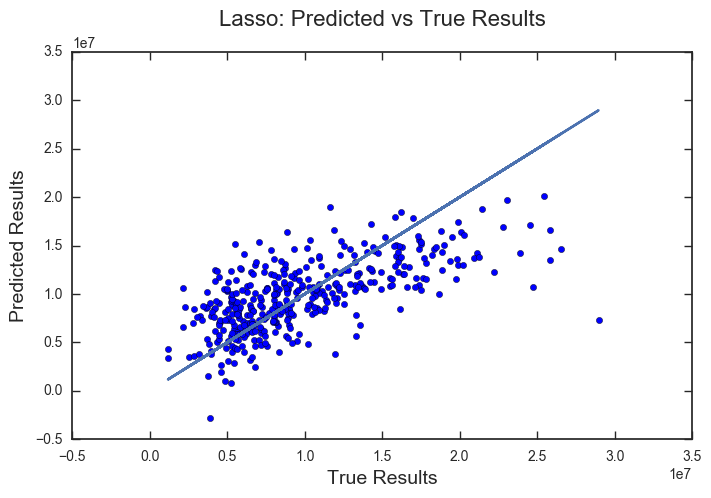

In [746]:
fig_l, ax_l = plt.subplots(1,1,figsize=(8,5))
ax_l.scatter(y_lasso_holdout, y_pred_l, alpha=1)
ax_l.plot(y_lasso_holdout, y_lasso_holdout)
ax_l.set_title('Lasso: Predicted vs True Results', fontsize='16')
ax_l.set_xlabel('True Results', fontsize='14')
ax_l.set_ylabel('Predicted Results',fontsize='14')

sns.set_style("white")
sns.set_style('ticks')
sns.set_style({'xtick.direction': u'in', 'ytick.direction': u'in'})

ttl_l = ax_l.title
ttl_l.set_position([.5, 1.05])

In [773]:
X_rf_holdout = holdout[rf_cols]
y_rf_holdout = holdout['salary_adj']

random_forest = RandomForestRegressor(min_samples_split=5, max_depth=5, max_features='auto', n_estimators=300)
random_forest.fit(X_train_rf.append(X_test_rf), y_train_rf.append(y_test_rf))
y_pred_rf = random_forest.predict(X_rf_holdout)
random_forest.score(X_rf_holdout, y_rf_holdout)

0.36734322431409694

In [682]:
sorted(zip(random_forest.feature_importances_, rf_cols), reverse=True)

[(0.21915235461482402, 'PER_sq'),
 (0.077377427094435097, 'Age_cube'),
 (0.074530022580351865, 'PER'),
 (0.073192445744582807, 'Age'),
 (0.072213724124162035, 'Age_sq'),
 (0.061163557920318919, 'USG%'),
 (0.058723019302410473, 'USG%_cube'),
 (0.046612430865444344, 'USG%_sq'),
 (0.041440574263541467, 'GS_sq'),
 (0.041292793464155784, 'GS'),
 (0.015446957957005712, '2P'),
 (0.015266474351825083, 'DRB%'),
 (0.014762796307324084, 'DRB'),
 (0.012752097753354423, 'DBPM'),
 (0.01086019809678147, 'FTA'),
 (0.010249971062386643, 'FG'),
 (0.0083056726266983426, '2P%'),
 (0.0061821467492086859, 'ORB'),
 (0.0059869100775622871, 'BLK'),
 (0.0053197784595053373, 'BLK/TRB'),
 (0.0048570375810426695, 'PTS'),
 (0.0046551494113846676, 'eFG%'),
 (0.0045737118879394679, 'PF'),
 (0.0045428038314191824, 'FG%'),
 (0.0043683383012614761, '2PA'),
 (0.0042526993208324964, 'WS/48'),
 (0.0041993980405974083, 'TRB%'),
 (0.0041785641064511388, 'FT%'),
 (0.0041639404033720828, 'WS/OWS'),
 (0.0040390172057284783, 'ST

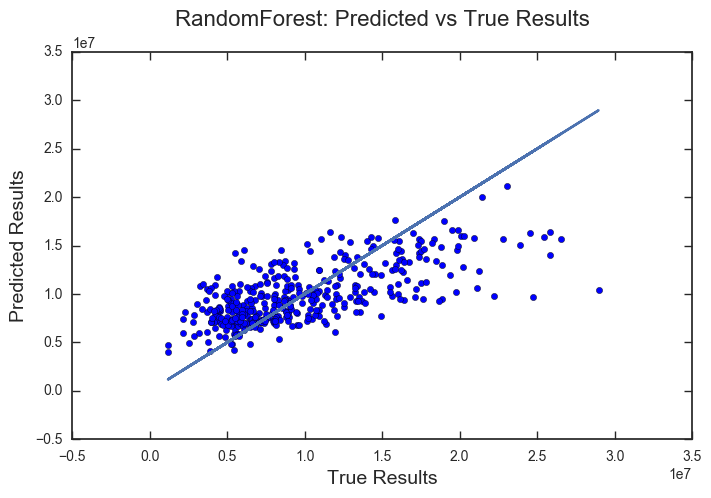

In [664]:
fig_rf, ax_rf = plt.subplots(1,1,figsize=(8,5))
ax_rf.scatter(y_rf_holdout, y_pred_rf, alpha=1)
ax_rf.plot(y_rf_holdout, y_rf_holdout)
ax_rf.set_title('RandomForest: Predicted vs True Results', fontsize='16')
ax_rf.set_xlabel('True Results', fontsize='14')
ax_rf.set_ylabel('Predicted Results',fontsize='14')

sns.set_style("white")
sns.set_style('ticks')
sns.set_style({'xtick.direction': u'in', 'ytick.direction': u'in'})

ttl_rf = ax_rf.title
ttl_rf.set_position([.5, 1.05])

In [772]:
X_gb_holdout = holdout[grad_cols]
y_gb_holdout = holdout['salary_adj']

gradient_boost = GradientBoostingRegressor(max_depth=5, min_samples_split=20, max_features='sqrt', n_estimators=100)

gradient_boost.fit(X_train_gb.append(X_test_gb), y_train_gb.append(y_test_gb))
y_pred_gb = gradient_boost.predict(X_gb_holdout)
gradient_boost.score(X_gb_holdout, y_gb_holdout)

0.46522999638411883

In [742]:
sorted(zip(gradient_boost.feature_importances_, grad_cols), reverse=True)

[(0.03755414624910168, 'PF'),
 (0.033645831068516055, 'Age'),
 (0.033265654810259684, 'Age_cube'),
 (0.031838176408801232, 'DRB%'),
 (0.031627019046916179, 'DRB'),
 (0.031615082397940607, 'WS/48'),
 (0.031381796052803758, 'AST%'),
 (0.029610793917821569, 'USG%'),
 (0.029274599105205235, 'USG%_sq'),
 (0.028375986298131827, '2PA'),
 (0.028083464214212702, '3PAr'),
 (0.027625680825876443, 'FGA'),
 (0.027322439005741425, 'AST'),
 (0.02713043245173577, 'MP'),
 (0.026793980671361468, 'PER_sq'),
 (0.02668934880734258, 'BLK%'),
 (0.025596650852475721, 'FTr'),
 (0.025532385724464604, 'BPM'),
 (0.025297082461243806, 'G_cube'),
 (0.024589084455510449, '2P'),
 (0.02458822851772834, 'FT%'),
 (0.023579595514084853, 'OWS'),
 (0.022898847396342448, 'FG%'),
 (0.022667026327298556, 'GS_sq'),
 (0.022501885740698006, 'GS'),
 (0.021857282389171531, 'FG'),
 (0.021773019703770692, 'DBPM'),
 (0.02162324349749992, 'ORB%'),
 (0.021464870197587013, 'PER'),
 (0.020340210572431808, 'ORB'),
 (0.02026872551944783, '

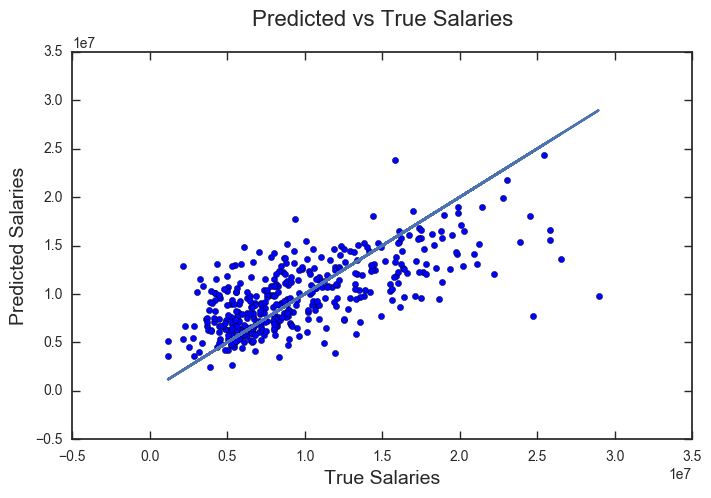

In [743]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.scatter(y_gb_holdout, y_pred_gb)
ax.plot(y_gb_holdout, y_gb_holdout)
ax.set_xlabel('True Salaries', fontsize='14')
ax.set_ylabel('Predicted Salaries',fontsize='14')
ax.set_title('Predicted vs True Salaries',fontsize='16')

sns.set_style("white")
sns.set_style('ticks')
sns.set_style({'xtick.direction': u'in', 'ytick.direction': u'in'})

ttl_gb = ax.title
ttl_gb.set_position([.5, 1.05])



## Plot the hyper parameters versus the test/training score

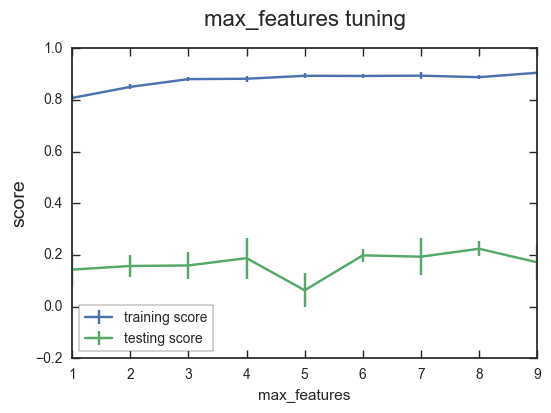

In [615]:
plot_overfit(X_gb_holdout, y_gb_holdout, GradientBoostingRegressor, {'max_features':range(1,10)})

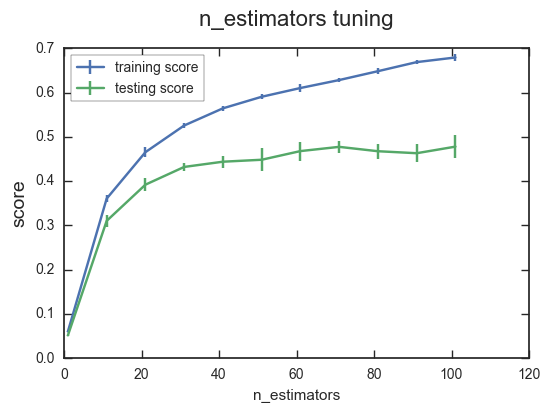

In [616]:
plot_overfit(X_gb, y_gb, GradientBoostingRegressor, {'n_estimators':range(1,110,10)})

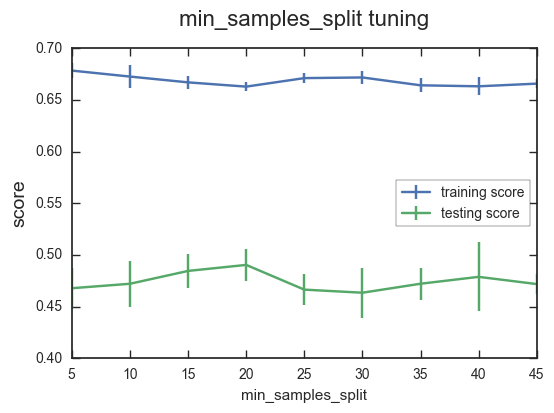

In [617]:
plot_overfit(X_gb, y_gb, GradientBoostingRegressor, {'min_samples_split':range(5,50,5)})

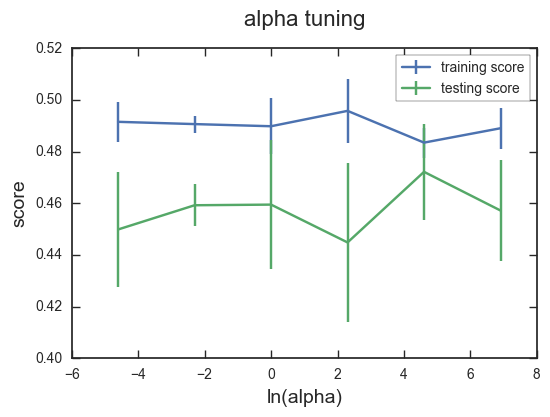

In [618]:
plot_overfit(X_gb, y_gb, linear_model.Lasso, {'alpha':[.01,.1,1,10,100,1000]})

## Plot PER vs Salary and highlight the outliers (if any)

In [686]:
worst = df_final[df_final['PER'] < -18]
worst

Unnamed: 0       NAME    Yr    SALARY  salary_adj   Tm  Age  G  MP   PER  \
921         921  Vin Baker  2005  14625000    18878014  HOU   33  3  13 -18.3   

      ...    PTS  STL  TOV  TRB  eFG%  Pos_C  Pos_PF  Pos_PG  Pos_SF  Pos_SG  
921   ...      2    0    2    2   0.0    1.0     0.0     0.0     0.0     0.0  

[1 rows x 57 columns]

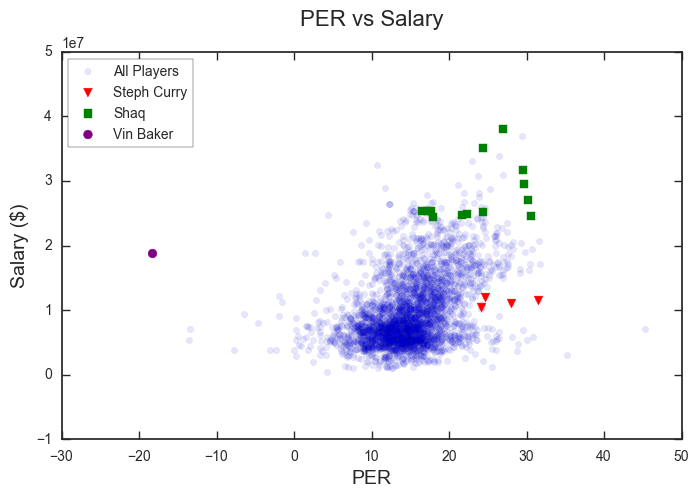

In [694]:
fig_PER, ax_PER = plt.subplots(1,1,figsize=(8,5))

PER_list = df_final['PER'].tolist()
salary_list = df_final['salary_adj'].tolist()

steph = df_final[df_final['NAME'] == 'Stephen Curry']
steph_PER = steph['PER'].tolist()
steph_sal = steph['salary_adj'].tolist()

shaq = df_final[df_final['NAME'] == "Shaquille O'Neal"]
shaq_PER = shaq['PER'].tolist()
shaq_sal = shaq['salary_adj'].tolist()

vin = df_final[df_final['PER'] < -18]
vin_PER = vin['PER'].tolist()
vin_sal = vin['salary_adj'].tolist()

ax_PER.scatter(PER_list, salary_list, label='All Players', alpha=.1)
ax_PER.scatter(steph_PER, steph_sal, color='red', label='Steph Curry', marker='v', s=40)
ax_PER.scatter(shaq_PER, shaq_sal, color='green', label='Shaq', marker='s', s=40)
ax_PER.scatter(vin_PER, vin_sal, color='purple', label='Vin Baker', marker='o', s=40)

ax_PER.set_title('PER vs Salary', fontsize='16')
ax_PER.set_xlabel('PER', fontsize='14')
ax_PER.set_ylabel('Salary ($)', fontsize='14')
ax_PER.legend(loc=2)

sns.set_style("white")
sns.set_style('ticks')
sns.set_style({'xtick.direction': u'in', 'ytick.direction': u'in'})
sns.set_style({'legend.frameon': True})

ttl_PER = ax_PER.title
ttl_PER.set_position([.5, 1.05])

In [698]:
# Average of 11 runs of the model with different holdout and train/test sets.
l_avg = [.526,.45,.515,.44,.525,.433,.479,.539,.471,.456,.504]
rf_avg = [.548,.468,.549,.503,.522,.454,.489,.573,.497,.52,.487]
gb_avg = [.86,.789,.841,.827,.864,.820,.767,.833,.823,.827,.827]

avgs = [l_avg, rf_avg, gb_avg]

for avg in avgs:
    print('AVG: ', np.mean(avg))
    print('STD: ', np.std(avg))
    print('\n')


AVG:  0.485272727273
STD:  0.0362869646244


AVG:  0.51
STD:  0.0347275107084


AVG:  0.825272727273
STD:  0.0265709715465


